# Deep Learning Project Work  
<a href="https://colab.research.google.com/drive/1Alwwnt0Ho4HYuWPxc6lluQ4NXnqPSC2s?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Source material:
- https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac
- https://www.kaggle.com/code/danieldelro/unsupervised-anomaly-segmentation-of-screw-images 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision
import math

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# Downloading data from the MVTecAD database - Carpet and Hazelnut categories were used

!wget https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937545-1629951845/hazelnut.tar.xz
!wget https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937484-1629951672/carpet.tar.xz
!tar -xf hazelnut.tar.xz 
!tar -xf carpet.tar.xz

--2022-11-20 16:54:52--  https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937545-1629951845/hazelnut.tar.xz
Resolving www.mydrive.ch (www.mydrive.ch)... 91.214.169.64
Connecting to www.mydrive.ch (www.mydrive.ch)|91.214.169.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 617098680 (589M) [application/x-xz]
Saving to: ‘hazelnut.tar.xz’

hazelnut.tar.xz     100%[===================>] 588.51M  10.2MB/s    in 62s     

2022-11-20 16:55:55 (9.57 MB/s) - ‘hazelnut.tar.xz’ saved [617098680/617098680]

--2022-11-20 16:55:55--  https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937484-1629951672/carpet.tar.xz
Resolving www.mydrive.ch (www.mydrive.ch)... 91.214.169.64
Connecting to www.mydrive.ch (www.mydrive.ch)|91.214.169.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 740285760 (706M) [application/x-xz]
Saving to: ‘carpet.tar.xz’

carpet.tar.xz       100%[===================

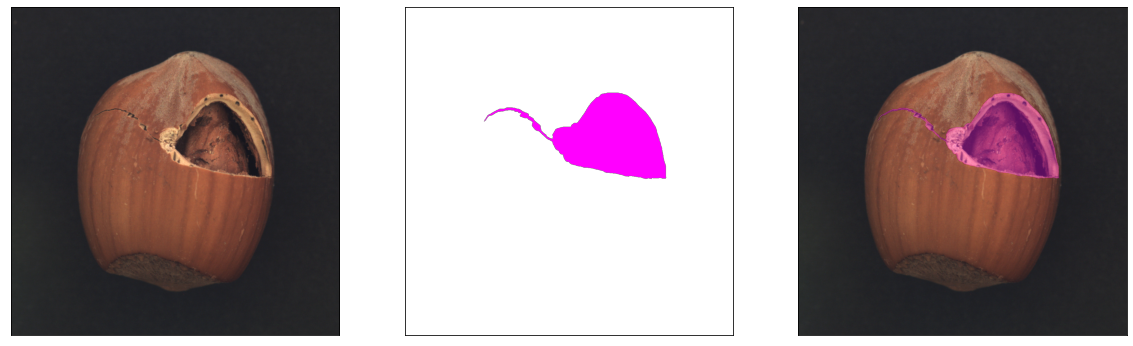

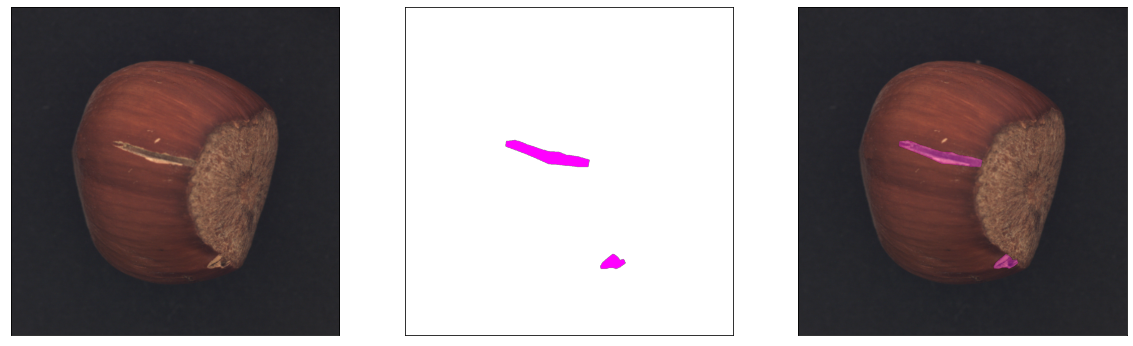

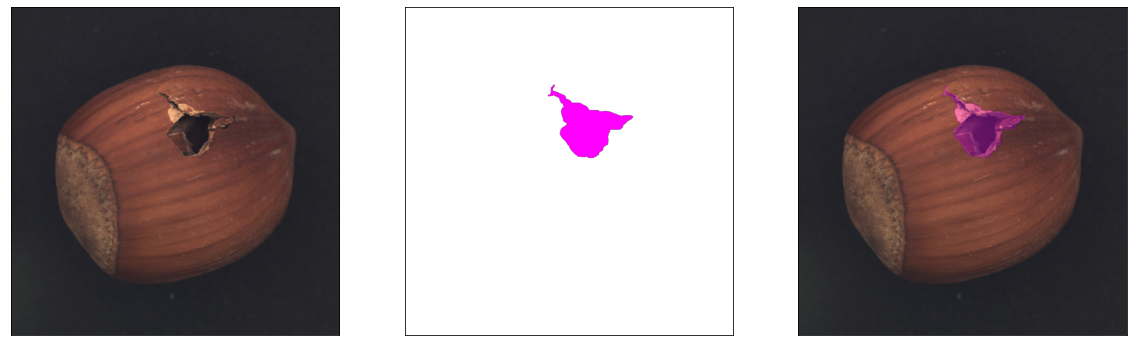

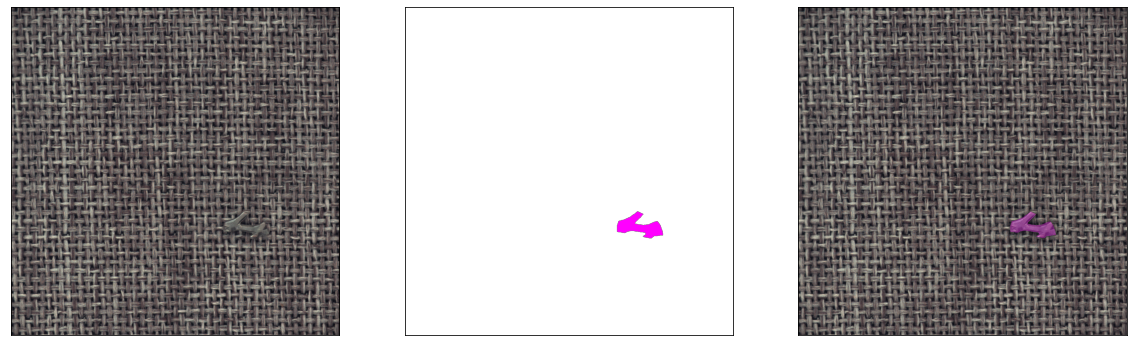

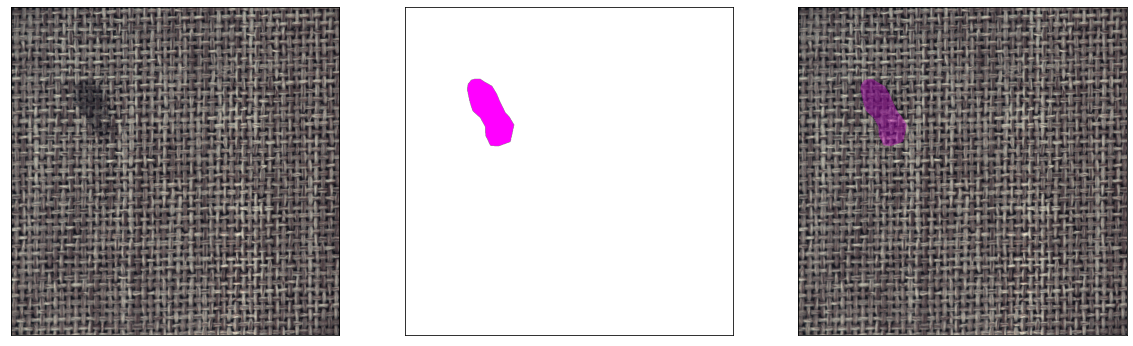

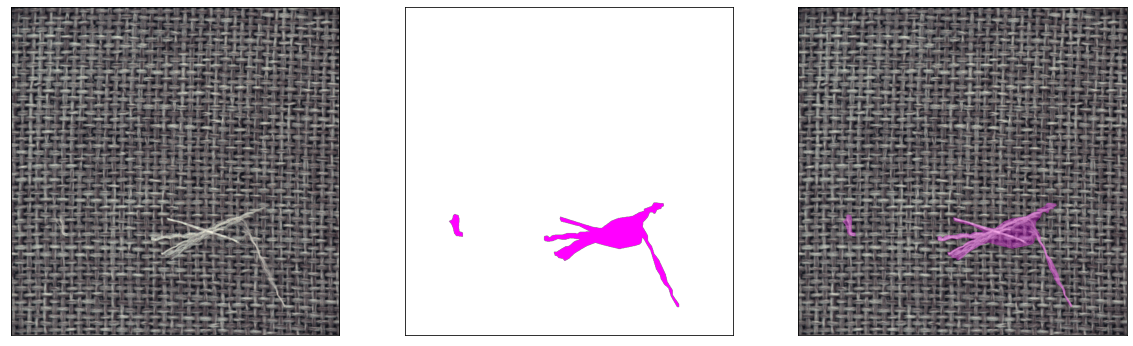

In [3]:
def test_image_visualization():

  image_paths = ['./hazelnut/test/crack/000.png','./hazelnut/test/cut/006.png',
                 './hazelnut//test/hole/013.png','./carpet/test/metal_contamination/004.png',
                 './carpet/test/color/005.png', './carpet/test/thread/008.png']
  mask_paths = ['./hazelnut/ground_truth/crack/000_mask.png','./hazelnut/ground_truth/cut/006_mask.png',
                './hazelnut/ground_truth/hole/013_mask.png','./carpet/ground_truth/metal_contamination/004_mask.png',
                './carpet/ground_truth/color/005_mask.png', './carpet/ground_truth/thread/008_mask.png']

  for i in range(0,len(image_paths)):

    msk = cv2.imread(str(mask_paths[i]))
    img = cv2.imread(str(image_paths[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    n_msk = mask_color_magenta(msk)
    plot_images(img, n_msk)
    
    
    
def plot_images(img, n_msk):

  plt.figure(figsize = (20,20))

  plt.subplot(131)
  plt.imshow(img)
  plt.xticks([]), plt.yticks([])

  plt.subplot(132)
  plt.imshow(n_msk)
  plt.xticks([]), plt.yticks([])

  plt.subplot(133)
  plt.imshow(img)
  plt.imshow(n_msk, alpha = 0.3)
  plt.xticks([]), plt.yticks([])
  
  plt.show()



def mask_color_magenta(img):
  # Modifies the original mask image - makes background transparent + sets the 
  # color of the segmented parts to magenta

  # separate R,G,B color channels and create a mask for the white pixels of the image
  mask = (img[:,:,0] == 255) & (img[:,:,1] == 255) & (img[:,:,2] == 255)
  # set the new color for white coloured pixels
  img[:,:,:3][mask] = [255,0,255] 
  # convert image to grayscale and "create a dimension for opacity"
  tmp = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  _, alpha = cv2.threshold(tmp, 0, 255, cv2.THRESH_BINARY)
  # split image by color channels and append 4th 'opacity' dimension
  b, g, r = cv2.split(img)
  rgba = [b, g, r, alpha]
  n_img = cv2.merge(rgba, 4)

  return n_img

test_image_visualization()

# Model section

Our model is a pretty simple autoencoder architecture with extra added convolutional layers. This convolutional section helps us better deal with image data. We have to keep the autoencoder architecture in mind, when designing the convolutional section, because in a way that the encoder's reverse is the decoder, this way our convolutional section has to have a deconvolutional section as well, which basically means using transposed convolutional layers.

In [4]:
import torch.nn as nn

class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [5]:
### Define the loss function
loss_fn = torch.nn.MSELoss()


lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks

## Latent dimension
d = 4

encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

### Define an optimizer (both for the encoder and the decoder!)
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

# Dataset and Dataloader creation

In [6]:
transform = torchvision.transforms.Compose([torchvision.transforms.Resize(28),
                                torchvision.transforms.ToTensor()
                               ])

hazelnut_train_dataset = torchvision.datasets.ImageFolder("./hazelnut/train/",transform=transform)
hazelnut_test_dataset = torchvision.datasets.ImageFolder("./hazelnut/test/",transform=transform)

carpet_train_dataset = torchvision.datasets.ImageFolder("./carpet/train/",transform=transform)
carpet_test_dataset = torchvision.datasets.ImageFolder("./carpet/test/",transform=transform)

hazelnut_test_length = int(len(hazelnut_test_dataset) * 0.8)
hazelnut_val_length = len(hazelnut_test_dataset) - hazelnut_test_length

carpet_test_length = int(len(carpet_test_dataset) * 0.8)
carpet_val_length = len(carpet_test_dataset) - carpet_test_length

hazelnut_test_dataset, hazelnut_val_dataset = torch.utils.data.random_split(hazelnut_test_dataset,[hazelnut_test_length,hazelnut_val_length],generator=torch.Generator().manual_seed(42))
carpet_test_dataset, carpet_val_dataset = torch.utils.data.random_split(carpet_test_dataset,[carpet_test_length,carpet_val_length],generator=torch.Generator().manual_seed(42))


hazelnut_train_loader  = torch.utils.data.DataLoader(hazelnut_train_dataset,batch_size=32,shuffle=True)
hazelnut_test_loader  = torch.utils.data.DataLoader(hazelnut_test_dataset,batch_size=32,shuffle=True)
hazelnut_val_loader  = torch.utils.data.DataLoader(hazelnut_val_dataset,batch_size=32,shuffle=True)
carpet_train_loader  = torch.utils.data.DataLoader(carpet_train_dataset,batch_size=32,shuffle=True)
carpet_test_loader  = torch.utils.data.DataLoader(carpet_test_dataset,batch_size=32,shuffle=True)
carpet_val_loader  = torch.utils.data.DataLoader(carpet_val_dataset,batch_size=32,shuffle=True)

hazelnut_vis_test_loader = torch.utils.data.DataLoader(hazelnut_test_dataset,batch_size=len(hazelnut_test_dataset))
carpet_vis_test_loader = torch.utils.data.DataLoader(carpet_test_dataset,batch_size=len(hazelnut_test_dataset))

# Train, Test, Evaluation, and Visualization functions

In [7]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [8]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [9]:
def plot_ae_outputs(encoder,decoder,vis_test_loader, n=5): # n stands for the number of classes
    plt.figure(figsize=(16,4.5))
    # Get the test images and labels from our loader
    images ,targets = next(iter(vis_test_loader))
    # Group them into a dictionary with keys as possible labels
    t_idx = {i:np.where(targets==i)[0] for i in range(n)}
    # Plot for each class
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      # Get our image from the test dataset
      img = images[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      # Put the test image through our autoencoder
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.T.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.T.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

In [10]:
def compute_threshold(encoder, decoder, dataset, fpr = 0.05):
    # Compute the error threshold on the trained model with training dataset.
    # The threshold is the q-th percentile of the output pixels' squared errors
    encoder.eval()
    decoder.eval()
    errors = []
    for img, _ in dataset:
        img = img.unsqueeze(0).to(device)
        with torch.no_grad():
            rec_img = decoder(encoder(img))

        error = torch.sum((rec_img - img)**2, axis=0)
        errors.append(error.T.cpu().squeeze().numpy())

    threshold = np.percentile(errors, 100-fpr)
    return threshold

In [11]:
def predict(encoder, decoder, dataset, threshold):
    # Calculates errors on the given dataset and compares it to the computed threshold (error > t.hold -> anomaly)
    # Returns a list of booleans, where each item is true if the model detected an anomaly.
    encoder.eval()
    decoder.eval()
    results = []
    for i, (img, label) in enumerate(dataset):
        img = img.unsqueeze(0).to(device)
        with torch.no_grad():
            rec_img = decoder(encoder(img))
            error = torch.sum((rec_img - img)**2, axis=0).T.cpu().squeeze().numpy()
        
        prediction = np.any(error > threshold)
        results.append(prediction)
        
    return results

In [12]:
def evaluation(encoder, decoder, dataset, threshold):
    # Calculates errors on the given (test) dataset and compares it to the computed threshold (error > t.hold -> anomaly)
    # Returns a list of booleans, where each item is true if the prediction is equal to the actual value
    encoder.eval()
    decoder.eval()
    results = []
    for i, (img, label) in enumerate(dataset):
        img = img.unsqueeze(0).to(device)
        with torch.no_grad():
            rec_img = decoder(encoder(img))
            error = torch.sum((rec_img - img)**2, axis=0).T.cpu().squeeze().numpy()
        
        prediction = np.any(error > threshold)
        label = (label == 0)
        results.append(1 if prediction == label else 0)
        
    return results

In [13]:
def experimental_evaluation(encoder, decoder, dataset, threshold, n=10):
    # Evaluation wiyh n samples and visualization 
    encoder.eval()
    decoder.eval()
    for i, (img, label) in enumerate(dataset):
        if i == n - 1:
            break
        
        img = img.unsqueeze(0).to(device)
        with torch.no_grad():
            rec_img = decoder(encoder(img))
        error = torch.sum((rec_img - img)**2, axis=0).T.cpu().squeeze().numpy()
        
        prediction = np.any(error > threshold)
        mask = np.where(error > threshold, 255, 0)
        
        _, axarr = plt.subplots(1,2, figsize=(15,15))
        axarr[0].imshow(img.T.cpu().squeeze().numpy(), cmap='gist_gray')
        axarr[1].imshow(img.T.cpu().squeeze().numpy(), cmap='gist_gray')
        axarr[1].imshow(mask, cmap='jet', alpha=0.5, interpolation='none')
        plt.show()

        print(f"Threshold: {threshold} MaxValue: {np.max(error)}")
        print(f"label: {label}, anomaly detected: {prediction}")

# Training loops

## Training on the hazelnut dataset

	 partial train loss (single batch): 0.120059
	 partial train loss (single batch): 0.117312
	 partial train loss (single batch): 0.113589
	 partial train loss (single batch): 0.109676
	 partial train loss (single batch): 0.108970
	 partial train loss (single batch): 0.107791
	 partial train loss (single batch): 0.106954
	 partial train loss (single batch): 0.103986
	 partial train loss (single batch): 0.102677
	 partial train loss (single batch): 0.100975
	 partial train loss (single batch): 0.102489
	 partial train loss (single batch): 0.098922
	 partial train loss (single batch): 0.095851

 EPOCH 1/30 	 train loss 0.10686548799276352 	 val loss 0.09903930872678757


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2981.)


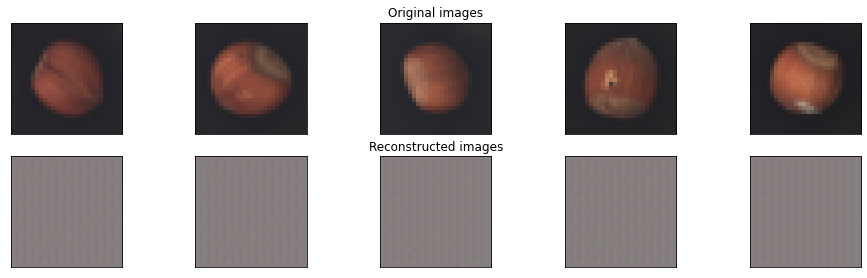

	 partial train loss (single batch): 0.097275
	 partial train loss (single batch): 0.093952
	 partial train loss (single batch): 0.095094
	 partial train loss (single batch): 0.093793
	 partial train loss (single batch): 0.091721
	 partial train loss (single batch): 0.088531
	 partial train loss (single batch): 0.089309
	 partial train loss (single batch): 0.087073
	 partial train loss (single batch): 0.086140
	 partial train loss (single batch): 0.083691
	 partial train loss (single batch): 0.083114
	 partial train loss (single batch): 0.083322
	 partial train loss (single batch): 0.083871

 EPOCH 2/30 	 train loss 0.08899132907390594 	 val loss 0.09172435849905014


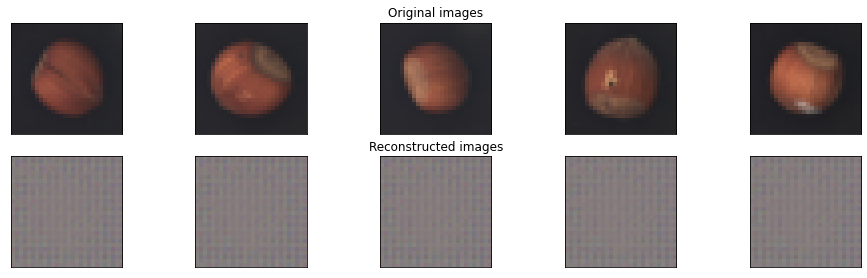

	 partial train loss (single batch): 0.081817
	 partial train loss (single batch): 0.078117
	 partial train loss (single batch): 0.079049
	 partial train loss (single batch): 0.076226
	 partial train loss (single batch): 0.077095
	 partial train loss (single batch): 0.074556
	 partial train loss (single batch): 0.072980
	 partial train loss (single batch): 0.074035
	 partial train loss (single batch): 0.070635
	 partial train loss (single batch): 0.069729
	 partial train loss (single batch): 0.068109
	 partial train loss (single batch): 0.066609
	 partial train loss (single batch): 0.065951

 EPOCH 3/30 	 train loss 0.07345438003540039 	 val loss 0.07922385632991791


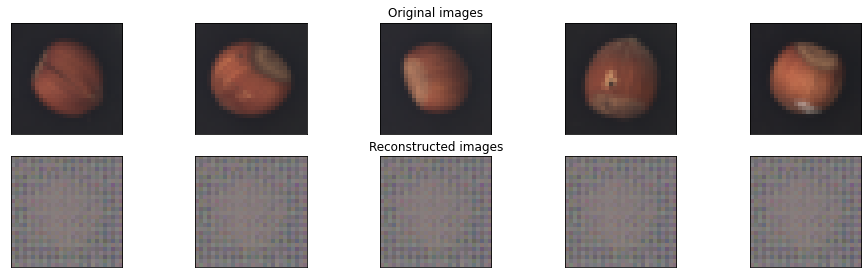

	 partial train loss (single batch): 0.065412
	 partial train loss (single batch): 0.064910
	 partial train loss (single batch): 0.064107
	 partial train loss (single batch): 0.063496
	 partial train loss (single batch): 0.062838
	 partial train loss (single batch): 0.060601
	 partial train loss (single batch): 0.061459
	 partial train loss (single batch): 0.059066
	 partial train loss (single batch): 0.059107
	 partial train loss (single batch): 0.057207
	 partial train loss (single batch): 0.056044
	 partial train loss (single batch): 0.054309
	 partial train loss (single batch): 0.054559

 EPOCH 4/30 	 train loss 0.060239508748054504 	 val loss 0.06031539663672447


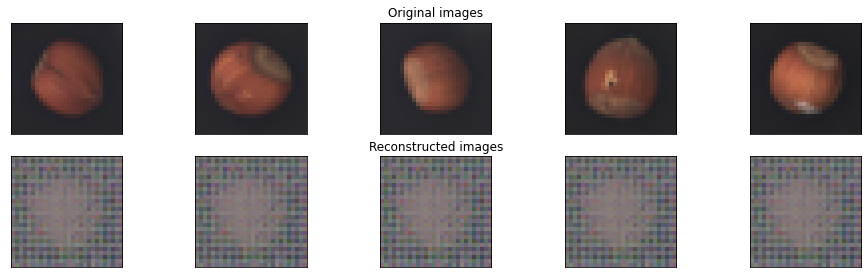

	 partial train loss (single batch): 0.054228
	 partial train loss (single batch): 0.053608
	 partial train loss (single batch): 0.053061
	 partial train loss (single batch): 0.051086
	 partial train loss (single batch): 0.050901
	 partial train loss (single batch): 0.050188
	 partial train loss (single batch): 0.049390
	 partial train loss (single batch): 0.046897
	 partial train loss (single batch): 0.047241
	 partial train loss (single batch): 0.046900
	 partial train loss (single batch): 0.046569
	 partial train loss (single batch): 0.045492
	 partial train loss (single batch): 0.045021

 EPOCH 5/30 	 train loss 0.049275465309619904 	 val loss 0.04336343705654144


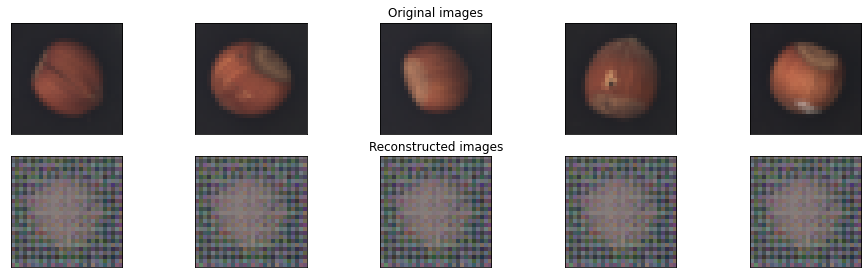

	 partial train loss (single batch): 0.045244
	 partial train loss (single batch): 0.043268
	 partial train loss (single batch): 0.043033
	 partial train loss (single batch): 0.041174
	 partial train loss (single batch): 0.040505
	 partial train loss (single batch): 0.041387
	 partial train loss (single batch): 0.040239
	 partial train loss (single batch): 0.040153
	 partial train loss (single batch): 0.038670
	 partial train loss (single batch): 0.037369
	 partial train loss (single batch): 0.038297
	 partial train loss (single batch): 0.038063
	 partial train loss (single batch): 0.038483

 EPOCH 6/30 	 train loss 0.04045270010828972 	 val loss 0.033301349729299545


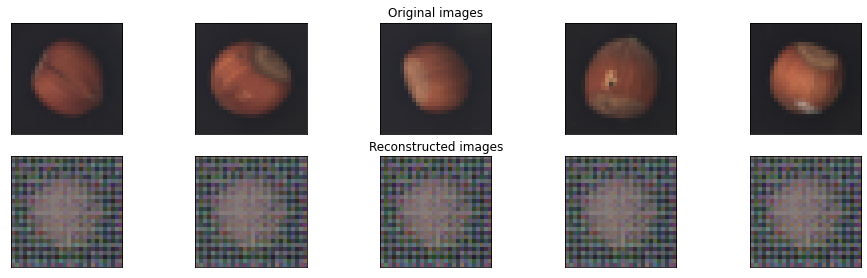

	 partial train loss (single batch): 0.036058
	 partial train loss (single batch): 0.036604
	 partial train loss (single batch): 0.036030
	 partial train loss (single batch): 0.034885
	 partial train loss (single batch): 0.034878
	 partial train loss (single batch): 0.033189
	 partial train loss (single batch): 0.033094
	 partial train loss (single batch): 0.032432
	 partial train loss (single batch): 0.031283
	 partial train loss (single batch): 0.032576
	 partial train loss (single batch): 0.030728
	 partial train loss (single batch): 0.029955
	 partial train loss (single batch): 0.031436

 EPOCH 7/30 	 train loss 0.03331906720995903 	 val loss 0.027038956061005592


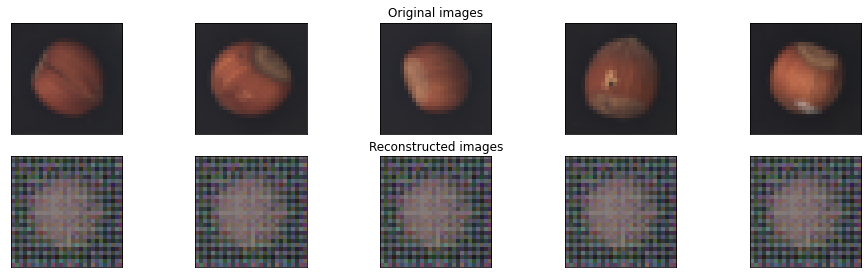

	 partial train loss (single batch): 0.029440
	 partial train loss (single batch): 0.028873
	 partial train loss (single batch): 0.028863
	 partial train loss (single batch): 0.029391
	 partial train loss (single batch): 0.028435
	 partial train loss (single batch): 0.027323
	 partial train loss (single batch): 0.028173
	 partial train loss (single batch): 0.027341
	 partial train loss (single batch): 0.027644
	 partial train loss (single batch): 0.026384
	 partial train loss (single batch): 0.026121
	 partial train loss (single batch): 0.026054
	 partial train loss (single batch): 0.025048

 EPOCH 8/30 	 train loss 0.027622390538454056 	 val loss 0.02194456197321415


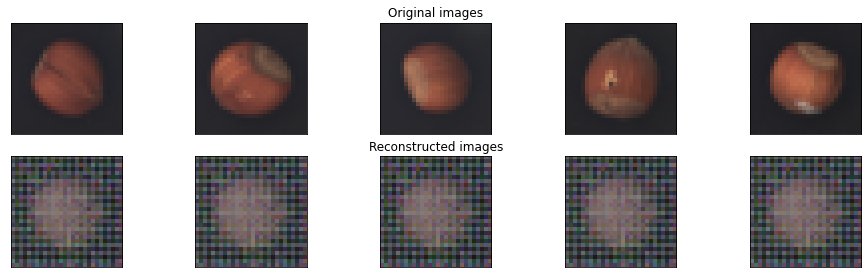

	 partial train loss (single batch): 0.025265
	 partial train loss (single batch): 0.024383
	 partial train loss (single batch): 0.024812
	 partial train loss (single batch): 0.023753
	 partial train loss (single batch): 0.023964
	 partial train loss (single batch): 0.023804
	 partial train loss (single batch): 0.023762
	 partial train loss (single batch): 0.022121
	 partial train loss (single batch): 0.022328
	 partial train loss (single batch): 0.022265
	 partial train loss (single batch): 0.022148
	 partial train loss (single batch): 0.022001
	 partial train loss (single batch): 0.021936

 EPOCH 9/30 	 train loss 0.023272452875971794 	 val loss 0.018738193437457085


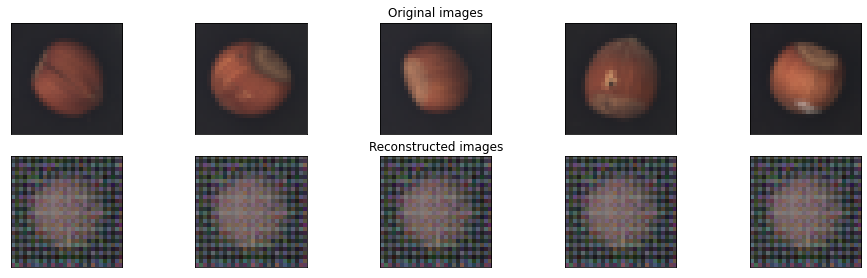

	 partial train loss (single batch): 0.021205
	 partial train loss (single batch): 0.021111
	 partial train loss (single batch): 0.020949
	 partial train loss (single batch): 0.020074
	 partial train loss (single batch): 0.019722
	 partial train loss (single batch): 0.020031
	 partial train loss (single batch): 0.019594
	 partial train loss (single batch): 0.019639
	 partial train loss (single batch): 0.019754
	 partial train loss (single batch): 0.019165
	 partial train loss (single batch): 0.018859
	 partial train loss (single batch): 0.018516
	 partial train loss (single batch): 0.017442

 EPOCH 10/30 	 train loss 0.019697017967700958 	 val loss 0.01635580323636532


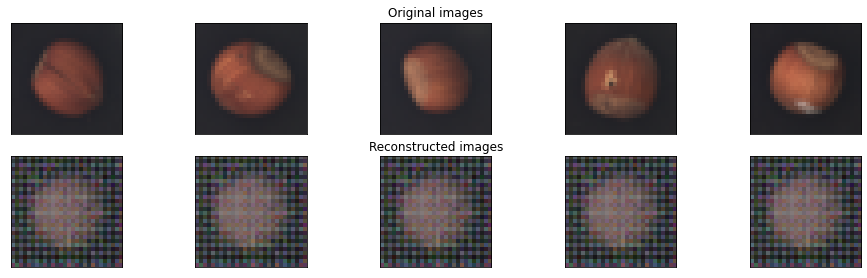

	 partial train loss (single batch): 0.018365
	 partial train loss (single batch): 0.017102
	 partial train loss (single batch): 0.018191
	 partial train loss (single batch): 0.017460
	 partial train loss (single batch): 0.017339
	 partial train loss (single batch): 0.016783
	 partial train loss (single batch): 0.017134
	 partial train loss (single batch): 0.017105
	 partial train loss (single batch): 0.017717
	 partial train loss (single batch): 0.016435
	 partial train loss (single batch): 0.016113
	 partial train loss (single batch): 0.015497
	 partial train loss (single batch): 0.015603

 EPOCH 11/30 	 train loss 0.016988154500722885 	 val loss 0.014006107114255428


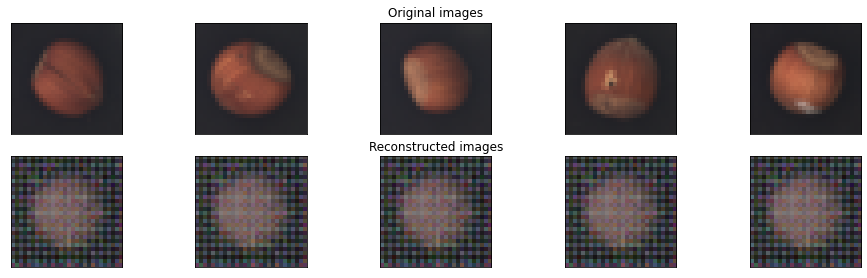

	 partial train loss (single batch): 0.015594
	 partial train loss (single batch): 0.016213
	 partial train loss (single batch): 0.015167
	 partial train loss (single batch): 0.014997
	 partial train loss (single batch): 0.014770
	 partial train loss (single batch): 0.014992
	 partial train loss (single batch): 0.014670
	 partial train loss (single batch): 0.014409
	 partial train loss (single batch): 0.014679
	 partial train loss (single batch): 0.014546
	 partial train loss (single batch): 0.013875
	 partial train loss (single batch): 0.014146
	 partial train loss (single batch): 0.014255

 EPOCH 12/30 	 train loss 0.01479331124573946 	 val loss 0.011846260167658329


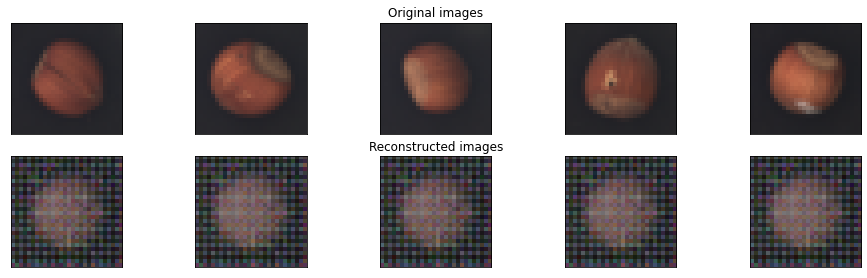

	 partial train loss (single batch): 0.013301
	 partial train loss (single batch): 0.012829
	 partial train loss (single batch): 0.014172
	 partial train loss (single batch): 0.013296
	 partial train loss (single batch): 0.012864
	 partial train loss (single batch): 0.013556
	 partial train loss (single batch): 0.012683
	 partial train loss (single batch): 0.013020
	 partial train loss (single batch): 0.013008
	 partial train loss (single batch): 0.012570
	 partial train loss (single batch): 0.012461
	 partial train loss (single batch): 0.012289
	 partial train loss (single batch): 0.011696

 EPOCH 13/30 	 train loss 0.012903525494039059 	 val loss 0.010323667898774147


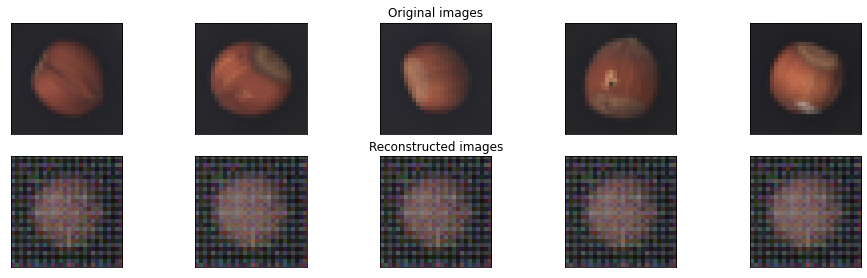

	 partial train loss (single batch): 0.012517
	 partial train loss (single batch): 0.011854
	 partial train loss (single batch): 0.011923
	 partial train loss (single batch): 0.011661
	 partial train loss (single batch): 0.011489
	 partial train loss (single batch): 0.011397
	 partial train loss (single batch): 0.011436
	 partial train loss (single batch): 0.011555
	 partial train loss (single batch): 0.011077
	 partial train loss (single batch): 0.011035
	 partial train loss (single batch): 0.011115
	 partial train loss (single batch): 0.011169
	 partial train loss (single batch): 0.009684

 EPOCH 14/30 	 train loss 0.011377975344657898 	 val loss 0.009545222856104374


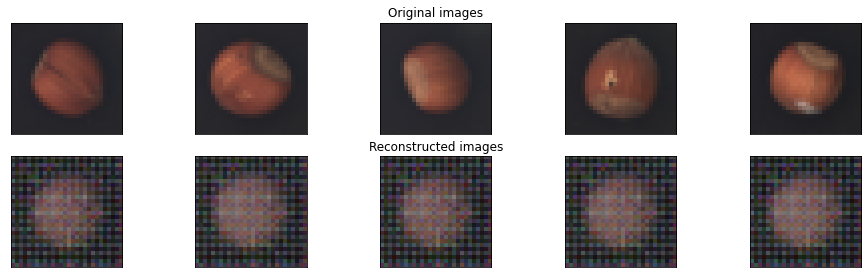

	 partial train loss (single batch): 0.010696
	 partial train loss (single batch): 0.010680
	 partial train loss (single batch): 0.010641
	 partial train loss (single batch): 0.010393
	 partial train loss (single batch): 0.010469
	 partial train loss (single batch): 0.010226
	 partial train loss (single batch): 0.010067
	 partial train loss (single batch): 0.009876
	 partial train loss (single batch): 0.010157
	 partial train loss (single batch): 0.009980
	 partial train loss (single batch): 0.010101
	 partial train loss (single batch): 0.010055
	 partial train loss (single batch): 0.009576

 EPOCH 15/30 	 train loss 0.010224276222288609 	 val loss 0.008636184968054295


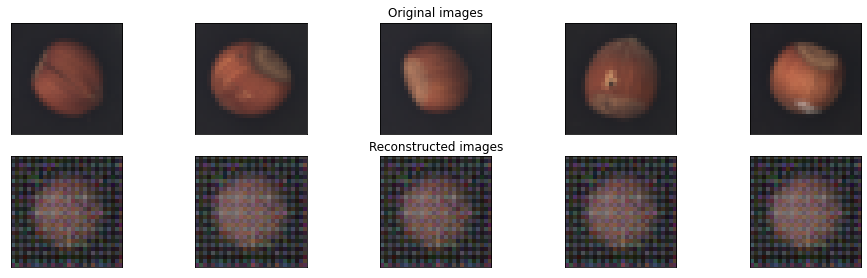

	 partial train loss (single batch): 0.009653
	 partial train loss (single batch): 0.009323
	 partial train loss (single batch): 0.009804
	 partial train loss (single batch): 0.009558
	 partial train loss (single batch): 0.009397
	 partial train loss (single batch): 0.009445
	 partial train loss (single batch): 0.009008
	 partial train loss (single batch): 0.009092
	 partial train loss (single batch): 0.008895
	 partial train loss (single batch): 0.009153
	 partial train loss (single batch): 0.008723
	 partial train loss (single batch): 0.009079
	 partial train loss (single batch): 0.009292

 EPOCH 16/30 	 train loss 0.009263178333640099 	 val loss 0.007860683836042881


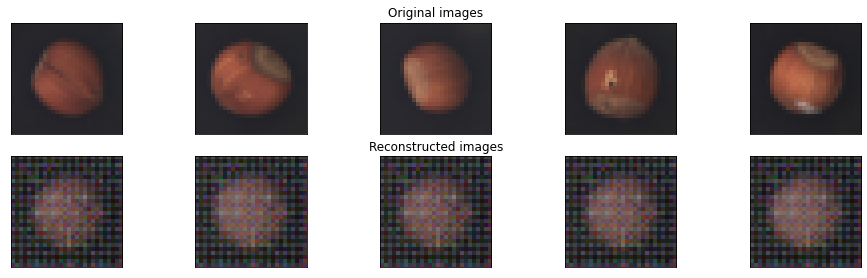

	 partial train loss (single batch): 0.008700
	 partial train loss (single batch): 0.008823
	 partial train loss (single batch): 0.008381
	 partial train loss (single batch): 0.008344
	 partial train loss (single batch): 0.008688
	 partial train loss (single batch): 0.008346
	 partial train loss (single batch): 0.008507
	 partial train loss (single batch): 0.008435
	 partial train loss (single batch): 0.008110
	 partial train loss (single batch): 0.008283
	 partial train loss (single batch): 0.008446
	 partial train loss (single batch): 0.007951
	 partial train loss (single batch): 0.009276

 EPOCH 17/30 	 train loss 0.008483799174427986 	 val loss 0.00762538006529212


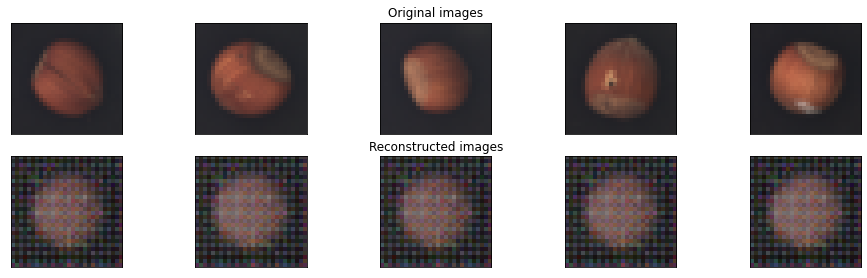

	 partial train loss (single batch): 0.007869
	 partial train loss (single batch): 0.007799
	 partial train loss (single batch): 0.007892
	 partial train loss (single batch): 0.007787
	 partial train loss (single batch): 0.007720
	 partial train loss (single batch): 0.007729
	 partial train loss (single batch): 0.007725
	 partial train loss (single batch): 0.007693
	 partial train loss (single batch): 0.007854
	 partial train loss (single batch): 0.007541
	 partial train loss (single batch): 0.007457
	 partial train loss (single batch): 0.007511
	 partial train loss (single batch): 0.007306

 EPOCH 18/30 	 train loss 0.0076831853948533535 	 val loss 0.006631099618971348


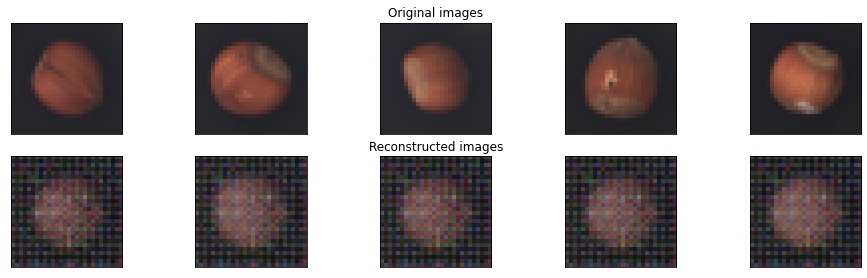

	 partial train loss (single batch): 0.007185
	 partial train loss (single batch): 0.007304
	 partial train loss (single batch): 0.007154
	 partial train loss (single batch): 0.006988
	 partial train loss (single batch): 0.007167
	 partial train loss (single batch): 0.007207
	 partial train loss (single batch): 0.007173
	 partial train loss (single batch): 0.007343
	 partial train loss (single batch): 0.007045
	 partial train loss (single batch): 0.006621
	 partial train loss (single batch): 0.006830
	 partial train loss (single batch): 0.006934
	 partial train loss (single batch): 0.006709

 EPOCH 19/30 	 train loss 0.00705083878710866 	 val loss 0.006133581046015024


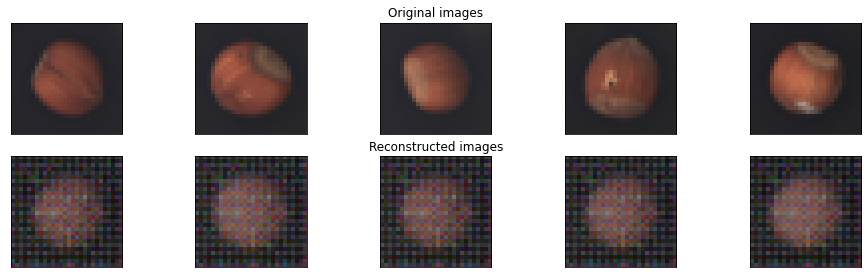

	 partial train loss (single batch): 0.006620
	 partial train loss (single batch): 0.006794
	 partial train loss (single batch): 0.006711
	 partial train loss (single batch): 0.006443
	 partial train loss (single batch): 0.006643
	 partial train loss (single batch): 0.006370
	 partial train loss (single batch): 0.006610
	 partial train loss (single batch): 0.006272
	 partial train loss (single batch): 0.006540
	 partial train loss (single batch): 0.006150
	 partial train loss (single batch): 0.006124
	 partial train loss (single batch): 0.006431
	 partial train loss (single batch): 0.006037

 EPOCH 20/30 	 train loss 0.006441852077841759 	 val loss 0.005708961747586727


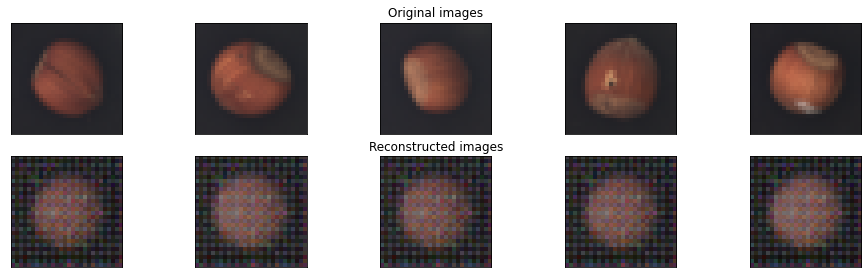

	 partial train loss (single batch): 0.005959
	 partial train loss (single batch): 0.006337
	 partial train loss (single batch): 0.006148
	 partial train loss (single batch): 0.005973
	 partial train loss (single batch): 0.006045
	 partial train loss (single batch): 0.006004
	 partial train loss (single batch): 0.005663
	 partial train loss (single batch): 0.006017
	 partial train loss (single batch): 0.006153
	 partial train loss (single batch): 0.005798
	 partial train loss (single batch): 0.005924
	 partial train loss (single batch): 0.005736
	 partial train loss (single batch): 0.005462

 EPOCH 21/30 	 train loss 0.005939819850027561 	 val loss 0.005355875473469496


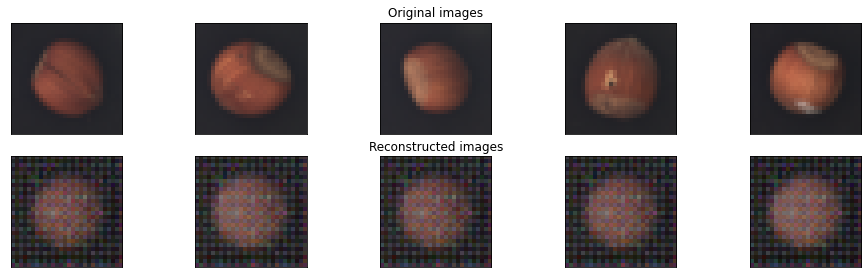

	 partial train loss (single batch): 0.005715
	 partial train loss (single batch): 0.005756
	 partial train loss (single batch): 0.005411
	 partial train loss (single batch): 0.005836
	 partial train loss (single batch): 0.005814
	 partial train loss (single batch): 0.005452
	 partial train loss (single batch): 0.005666
	 partial train loss (single batch): 0.005427
	 partial train loss (single batch): 0.005582
	 partial train loss (single batch): 0.005344
	 partial train loss (single batch): 0.005494
	 partial train loss (single batch): 0.005325
	 partial train loss (single batch): 0.005196

 EPOCH 22/30 	 train loss 0.005539820529520512 	 val loss 0.005058749113231897


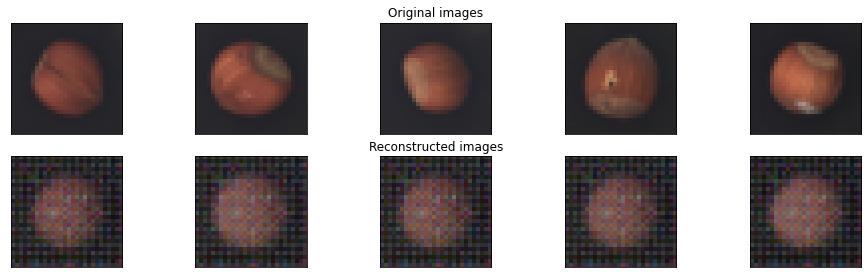

	 partial train loss (single batch): 0.005507
	 partial train loss (single batch): 0.005366
	 partial train loss (single batch): 0.004988
	 partial train loss (single batch): 0.005173
	 partial train loss (single batch): 0.005455
	 partial train loss (single batch): 0.005115
	 partial train loss (single batch): 0.005253
	 partial train loss (single batch): 0.005599
	 partial train loss (single batch): 0.005008
	 partial train loss (single batch): 0.005009
	 partial train loss (single batch): 0.004980
	 partial train loss (single batch): 0.004956
	 partial train loss (single batch): 0.005027

 EPOCH 23/30 	 train loss 0.005187449045479298 	 val loss 0.0047598229721188545


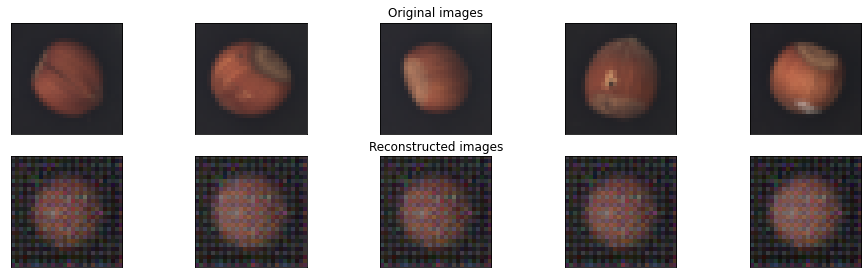

	 partial train loss (single batch): 0.005231
	 partial train loss (single batch): 0.004920
	 partial train loss (single batch): 0.005096
	 partial train loss (single batch): 0.005211
	 partial train loss (single batch): 0.004996
	 partial train loss (single batch): 0.004846
	 partial train loss (single batch): 0.005000
	 partial train loss (single batch): 0.005044
	 partial train loss (single batch): 0.004674
	 partial train loss (single batch): 0.004579
	 partial train loss (single batch): 0.004521
	 partial train loss (single batch): 0.004627
	 partial train loss (single batch): 0.005170

 EPOCH 24/30 	 train loss 0.004916615318506956 	 val loss 0.004647070541977882


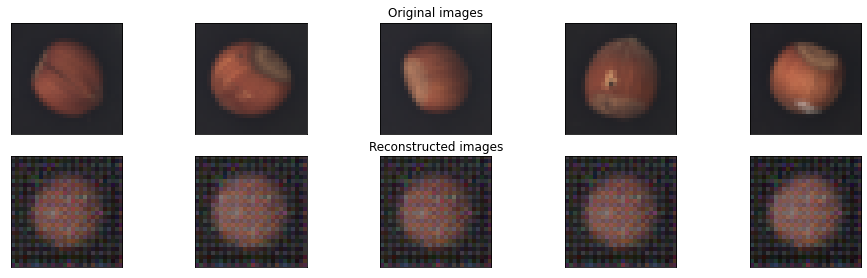

	 partial train loss (single batch): 0.004639
	 partial train loss (single batch): 0.004711
	 partial train loss (single batch): 0.004917
	 partial train loss (single batch): 0.004544
	 partial train loss (single batch): 0.004822
	 partial train loss (single batch): 0.004606
	 partial train loss (single batch): 0.004379
	 partial train loss (single batch): 0.004662
	 partial train loss (single batch): 0.004545
	 partial train loss (single batch): 0.004411
	 partial train loss (single batch): 0.004496
	 partial train loss (single batch): 0.004607
	 partial train loss (single batch): 0.004463

 EPOCH 25/30 	 train loss 0.004600207787007093 	 val loss 0.004336888901889324


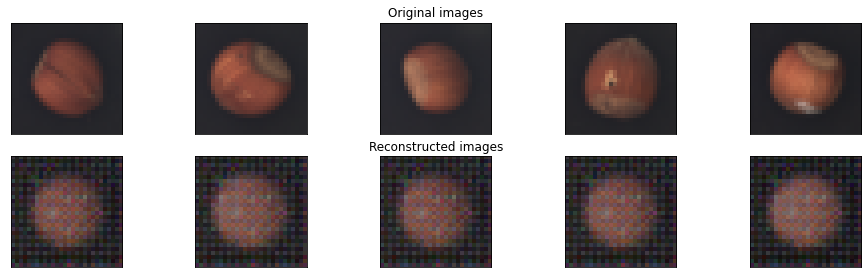

	 partial train loss (single batch): 0.004230
	 partial train loss (single batch): 0.004252
	 partial train loss (single batch): 0.004575
	 partial train loss (single batch): 0.004456
	 partial train loss (single batch): 0.004500
	 partial train loss (single batch): 0.004221
	 partial train loss (single batch): 0.004364
	 partial train loss (single batch): 0.004207
	 partial train loss (single batch): 0.004221
	 partial train loss (single batch): 0.004364
	 partial train loss (single batch): 0.004558
	 partial train loss (single batch): 0.004016
	 partial train loss (single batch): 0.003735

 EPOCH 26/30 	 train loss 0.004284505732357502 	 val loss 0.004004109650850296


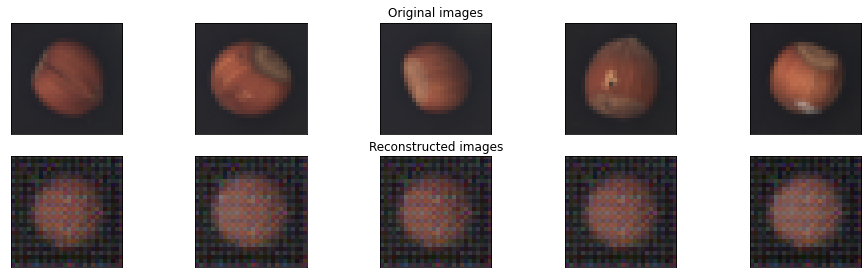

	 partial train loss (single batch): 0.004182
	 partial train loss (single batch): 0.004009
	 partial train loss (single batch): 0.004117
	 partial train loss (single batch): 0.004210
	 partial train loss (single batch): 0.003970
	 partial train loss (single batch): 0.004190
	 partial train loss (single batch): 0.004040
	 partial train loss (single batch): 0.003973
	 partial train loss (single batch): 0.004053
	 partial train loss (single batch): 0.004072
	 partial train loss (single batch): 0.003946
	 partial train loss (single batch): 0.003927
	 partial train loss (single batch): 0.004039

 EPOCH 27/30 	 train loss 0.004056080710142851 	 val loss 0.0038127386942505836


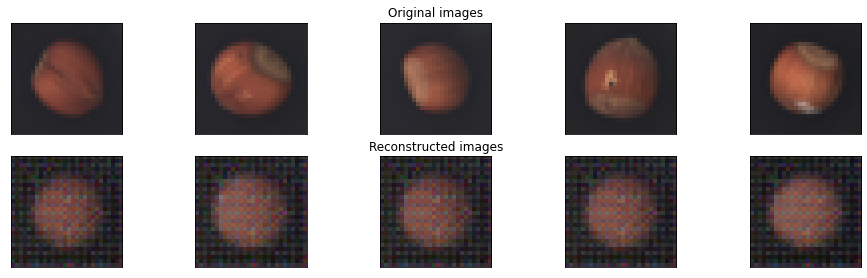

	 partial train loss (single batch): 0.003953
	 partial train loss (single batch): 0.003770
	 partial train loss (single batch): 0.003820
	 partial train loss (single batch): 0.003752
	 partial train loss (single batch): 0.004177
	 partial train loss (single batch): 0.003902
	 partial train loss (single batch): 0.003816
	 partial train loss (single batch): 0.003767
	 partial train loss (single batch): 0.003758
	 partial train loss (single batch): 0.003793
	 partial train loss (single batch): 0.003806
	 partial train loss (single batch): 0.003701
	 partial train loss (single batch): 0.004086

 EPOCH 28/30 	 train loss 0.003854036098346114 	 val loss 0.0037184925749897957


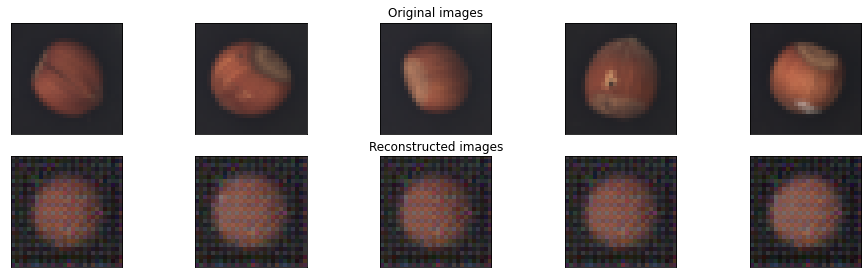

	 partial train loss (single batch): 0.003640
	 partial train loss (single batch): 0.003906
	 partial train loss (single batch): 0.003656
	 partial train loss (single batch): 0.003604
	 partial train loss (single batch): 0.003457
	 partial train loss (single batch): 0.003535
	 partial train loss (single batch): 0.003716
	 partial train loss (single batch): 0.003687
	 partial train loss (single batch): 0.003469
	 partial train loss (single batch): 0.003859
	 partial train loss (single batch): 0.003519
	 partial train loss (single batch): 0.003575
	 partial train loss (single batch): 0.003376

 EPOCH 29/30 	 train loss 0.003615238005295396 	 val loss 0.003562256461009383


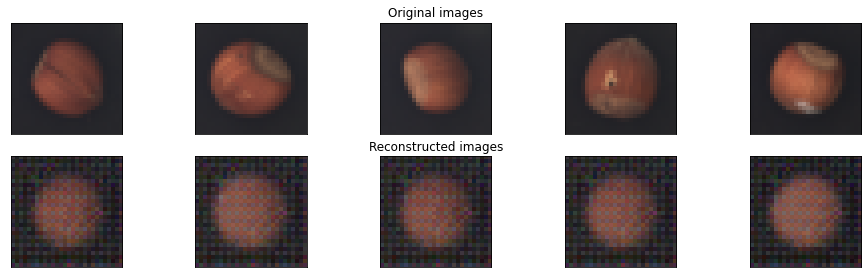

	 partial train loss (single batch): 0.003496
	 partial train loss (single batch): 0.003338
	 partial train loss (single batch): 0.003592
	 partial train loss (single batch): 0.003384
	 partial train loss (single batch): 0.003460
	 partial train loss (single batch): 0.003302
	 partial train loss (single batch): 0.003581
	 partial train loss (single batch): 0.003487
	 partial train loss (single batch): 0.003310
	 partial train loss (single batch): 0.003662
	 partial train loss (single batch): 0.003264
	 partial train loss (single batch): 0.003264
	 partial train loss (single batch): 0.003059

 EPOCH 30/30 	 train loss 0.0033998736180365086 	 val loss 0.0033262178767472506


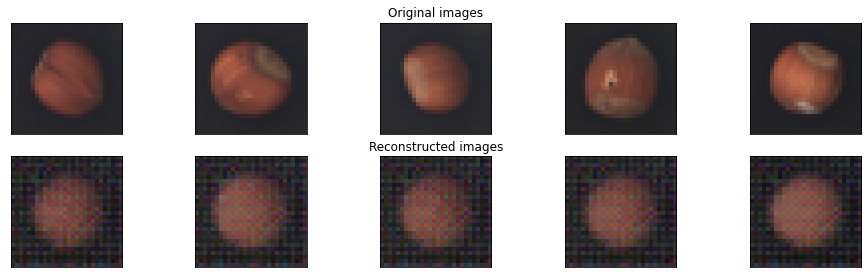

In [14]:
num_epochs = 30
# Unified loss dictionary
h_diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   # Calculate training loss
   h_train_loss =train_epoch(encoder,decoder,device,
   hazelnut_train_loader,loss_fn,optim)
   # Calculate validation loss
   h_val_loss = test_epoch(encoder,decoder,device,hazelnut_test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,h_train_loss,h_val_loss))
   h_diz_loss['train_loss'].append(h_train_loss)
   h_diz_loss['val_loss'].append(h_val_loss)
   plot_ae_outputs(encoder,decoder,hazelnut_vis_test_loader,n=5)

### Hazelnut losses

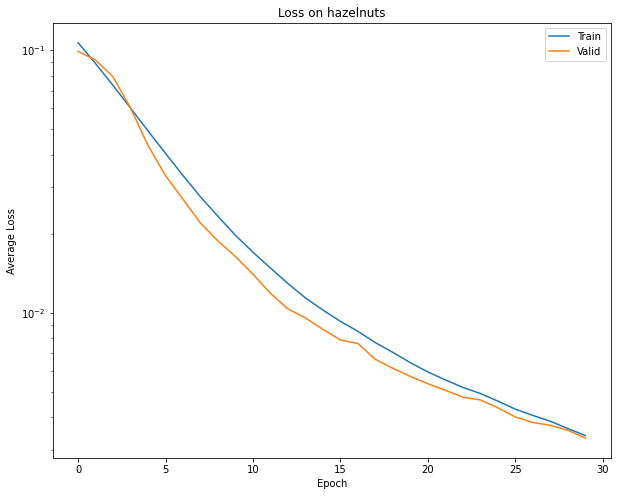

In [15]:
# Plot losses for hazelnuts
plt.figure(figsize=(10,8))
plt.semilogy(h_diz_loss['train_loss'], label='Train')
plt.semilogy(h_diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
plt.title('Loss on hazelnuts')
plt.show()

### Hazelnut test

In [16]:
test_epoch(encoder,decoder,device,hazelnut_test_loader,loss_fn).item()

0.0033262178767472506

### Hazelnut experimental evaluation

In [17]:
threshold = compute_threshold(encoder, decoder, hazelnut_train_dataset)
threshold

0.07865578664094376

Calculate the accuracy of the anomaly prediction on the test dataset, and visualize some samples

In [18]:
results = evaluation(encoder, decoder, hazelnut_test_dataset, threshold)
accuracy = sum(results) / len(results)
accuracy

0.6363636363636364

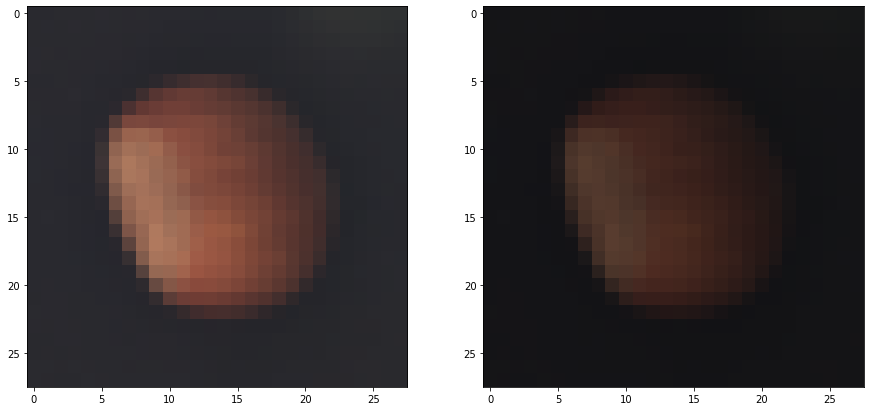

Threshold: 0.07865578664094376 MaxValue: 0.06815406680107117
label: 2, anomaly detected: False


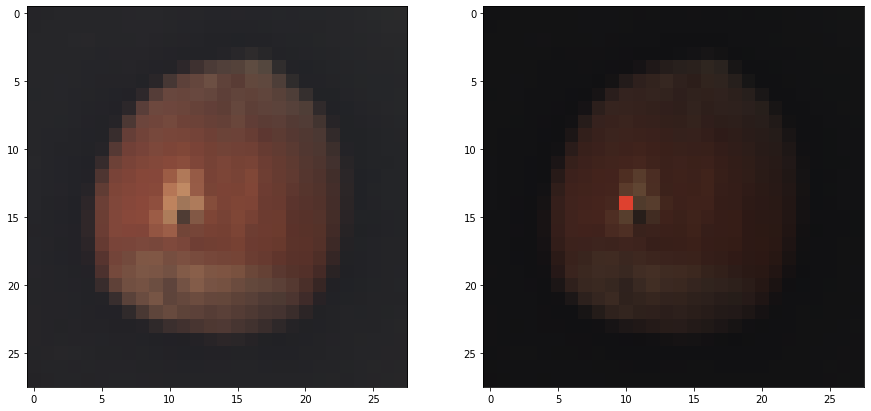

Threshold: 0.07865578664094376 MaxValue: 0.07878261804580688
label: 3, anomaly detected: True


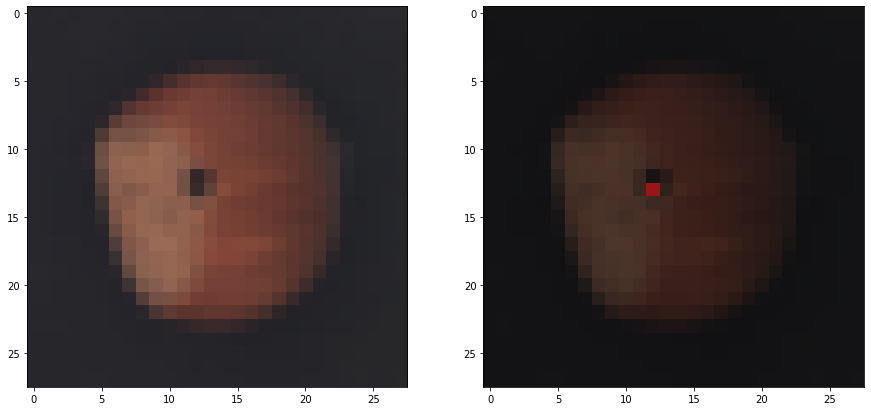

Threshold: 0.07865578664094376 MaxValue: 0.10676788538694382
label: 3, anomaly detected: True


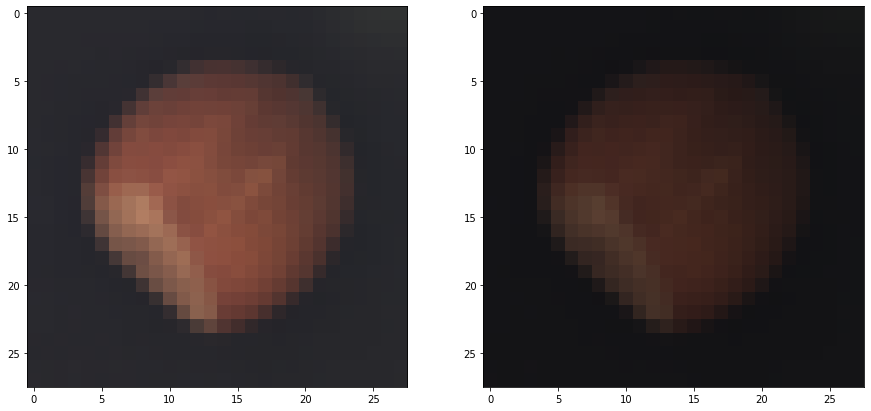

Threshold: 0.07865578664094376 MaxValue: 0.06675738841295242
label: 2, anomaly detected: False


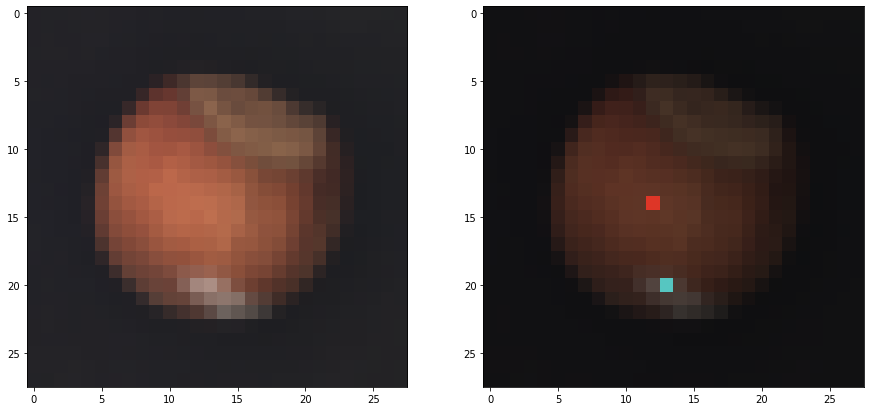

Threshold: 0.07865578664094376 MaxValue: 0.09884028881788254
label: 4, anomaly detected: True


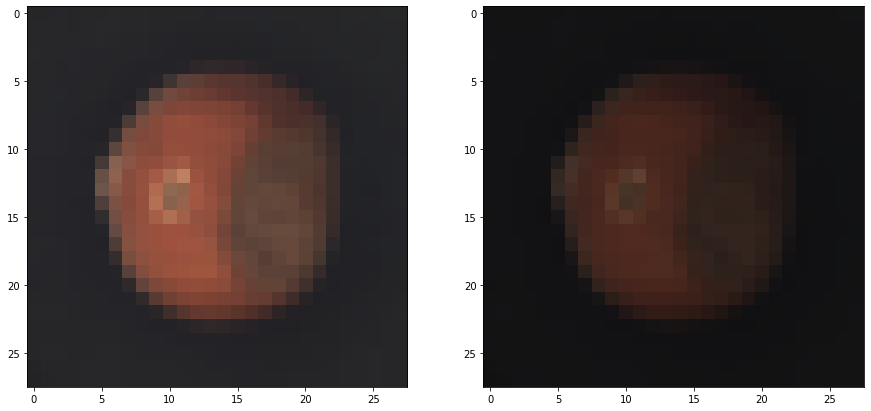

Threshold: 0.07865578664094376 MaxValue: 0.06921263784170151
label: 3, anomaly detected: False


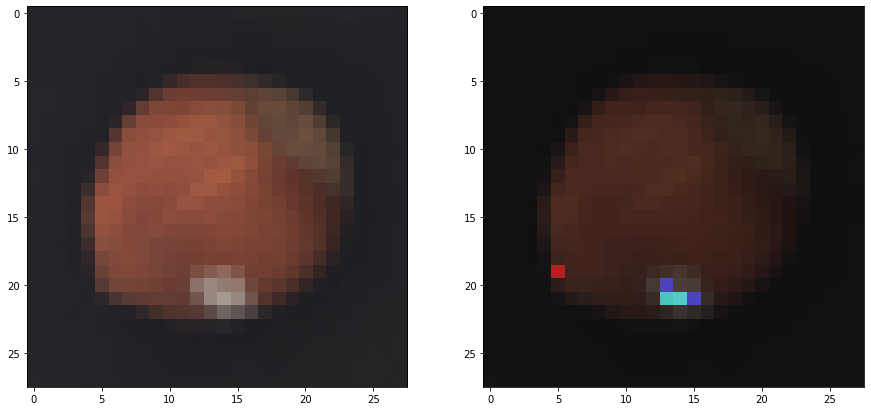

Threshold: 0.07865578664094376 MaxValue: 0.15917322039604187
label: 4, anomaly detected: True


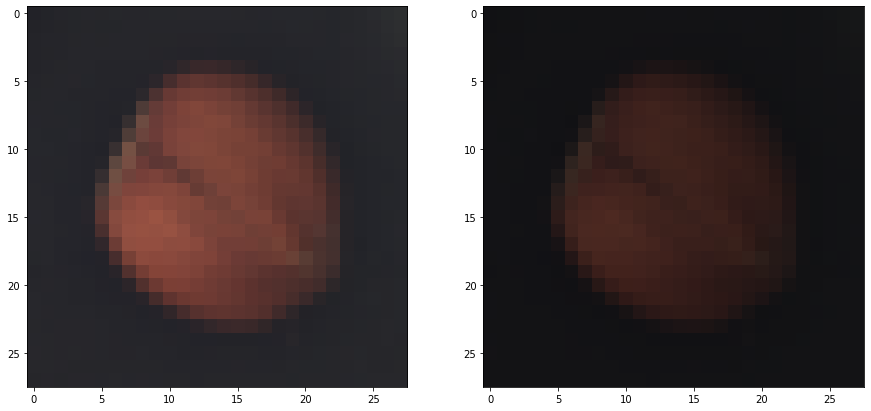

Threshold: 0.07865578664094376 MaxValue: 0.06761422008275986
label: 0, anomaly detected: False


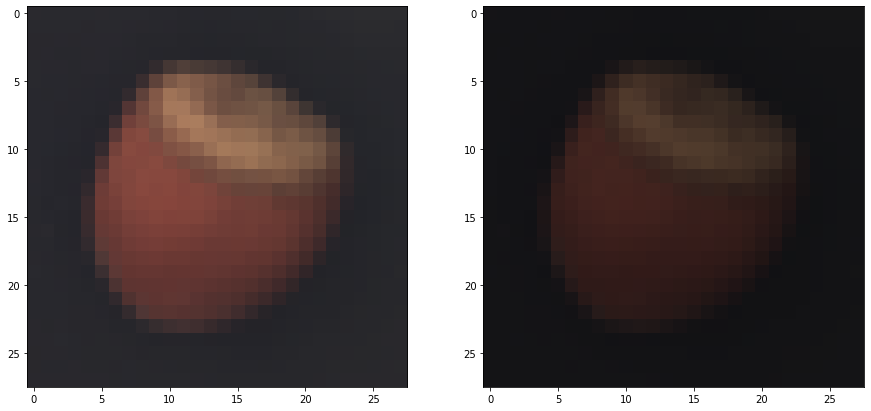

Threshold: 0.07865578664094376 MaxValue: 0.06742486357688904
label: 2, anomaly detected: False


In [19]:
experimental_evaluation(encoder, decoder, hazelnut_test_dataset, threshold)

#### Continue training with the carpet dataset

	 partial train loss (single batch): 0.031408
	 partial train loss (single batch): 0.030166
	 partial train loss (single batch): 0.028275
	 partial train loss (single batch): 0.026573
	 partial train loss (single batch): 0.025632
	 partial train loss (single batch): 0.022198
	 partial train loss (single batch): 0.020495
	 partial train loss (single batch): 0.017692
	 partial train loss (single batch): 0.015677

 EPOCH 1/30 	 train loss 0.024235151708126068 	 val loss 0.034637290984392166


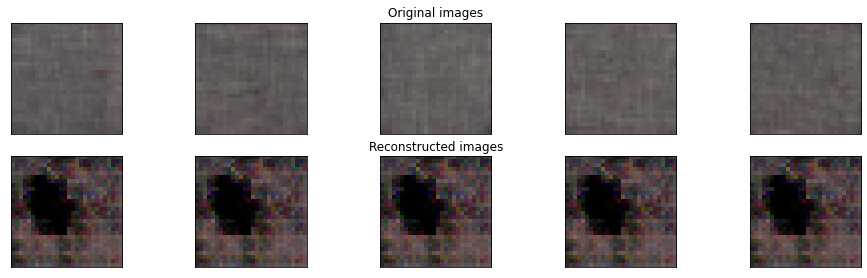

	 partial train loss (single batch): 0.013768
	 partial train loss (single batch): 0.012596
	 partial train loss (single batch): 0.011202
	 partial train loss (single batch): 0.010429
	 partial train loss (single batch): 0.009565
	 partial train loss (single batch): 0.008747
	 partial train loss (single batch): 0.008110
	 partial train loss (single batch): 0.007762
	 partial train loss (single batch): 0.007572

 EPOCH 2/30 	 train loss 0.009972337633371353 	 val loss 0.014227709732949734


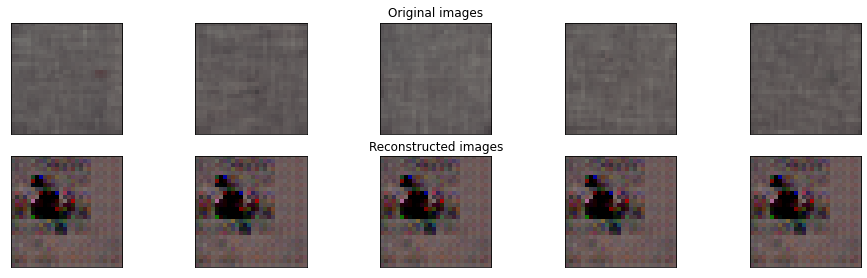

	 partial train loss (single batch): 0.007119
	 partial train loss (single batch): 0.007017
	 partial train loss (single batch): 0.006780
	 partial train loss (single batch): 0.006608
	 partial train loss (single batch): 0.006418
	 partial train loss (single batch): 0.006200
	 partial train loss (single batch): 0.006283
	 partial train loss (single batch): 0.006044
	 partial train loss (single batch): 0.005777

 EPOCH 3/30 	 train loss 0.006472040433436632 	 val loss 0.007840251550078392


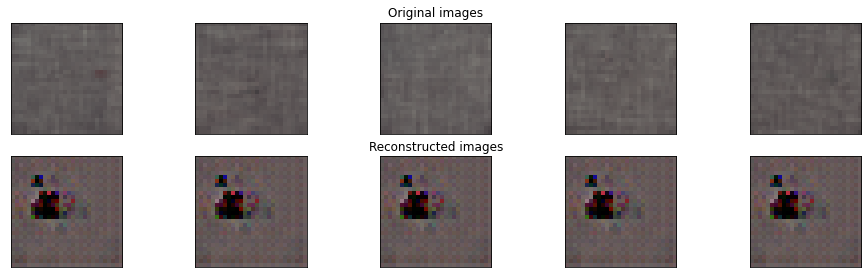

	 partial train loss (single batch): 0.005693
	 partial train loss (single batch): 0.005531
	 partial train loss (single batch): 0.005425
	 partial train loss (single batch): 0.005301
	 partial train loss (single batch): 0.005203
	 partial train loss (single batch): 0.004969
	 partial train loss (single batch): 0.004706
	 partial train loss (single batch): 0.004810
	 partial train loss (single batch): 0.004549

 EPOCH 4/30 	 train loss 0.0051318006590008736 	 val loss 0.003710651071742177


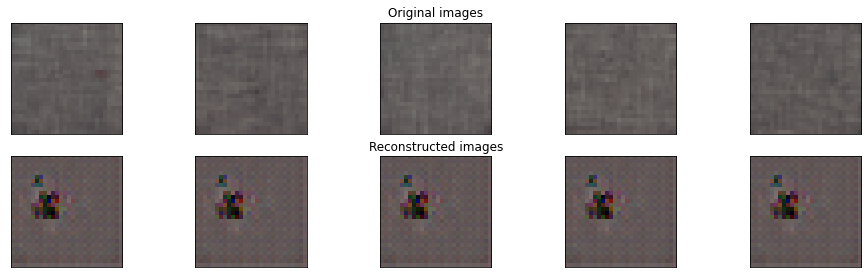

	 partial train loss (single batch): 0.004441
	 partial train loss (single batch): 0.004257
	 partial train loss (single batch): 0.004013
	 partial train loss (single batch): 0.003920
	 partial train loss (single batch): 0.003648
	 partial train loss (single batch): 0.003786
	 partial train loss (single batch): 0.003581
	 partial train loss (single batch): 0.003409
	 partial train loss (single batch): 0.003208

 EPOCH 5/30 	 train loss 0.003806998021900654 	 val loss 0.0019425266655161977


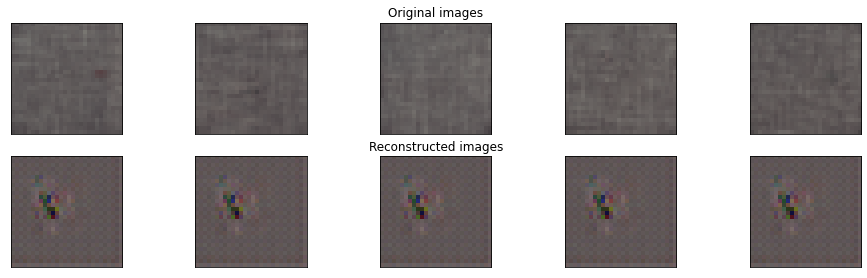

	 partial train loss (single batch): 0.003072
	 partial train loss (single batch): 0.002898
	 partial train loss (single batch): 0.002907
	 partial train loss (single batch): 0.002585
	 partial train loss (single batch): 0.002450
	 partial train loss (single batch): 0.002486
	 partial train loss (single batch): 0.002220
	 partial train loss (single batch): 0.002278
	 partial train loss (single batch): 0.002223

 EPOCH 6/30 	 train loss 0.002568921772763133 	 val loss 0.0013889300171285868


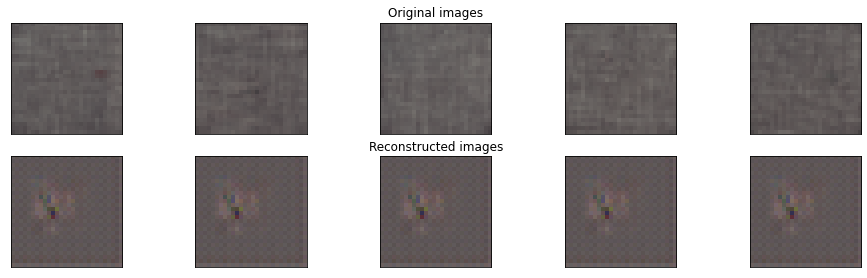

	 partial train loss (single batch): 0.002068
	 partial train loss (single batch): 0.001850
	 partial train loss (single batch): 0.001857
	 partial train loss (single batch): 0.001803
	 partial train loss (single batch): 0.001808
	 partial train loss (single batch): 0.001707
	 partial train loss (single batch): 0.001692
	 partial train loss (single batch): 0.001685
	 partial train loss (single batch): 0.001754

 EPOCH 7/30 	 train loss 0.0018027027836069465 	 val loss 0.0011479256208986044


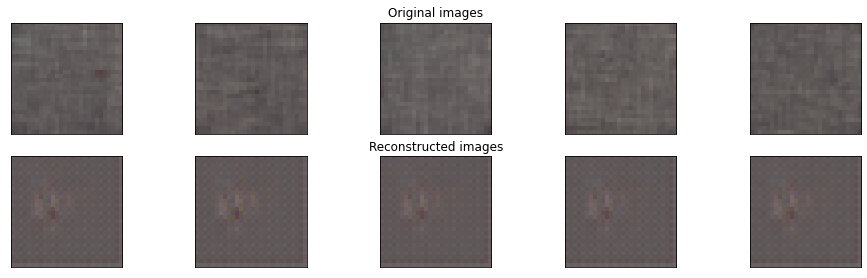

	 partial train loss (single batch): 0.001613
	 partial train loss (single batch): 0.001544
	 partial train loss (single batch): 0.001564
	 partial train loss (single batch): 0.001561
	 partial train loss (single batch): 0.001568
	 partial train loss (single batch): 0.001525
	 partial train loss (single batch): 0.001516
	 partial train loss (single batch): 0.001414
	 partial train loss (single batch): 0.001447

 EPOCH 8/30 	 train loss 0.001528097433038056 	 val loss 0.0010467070387676358


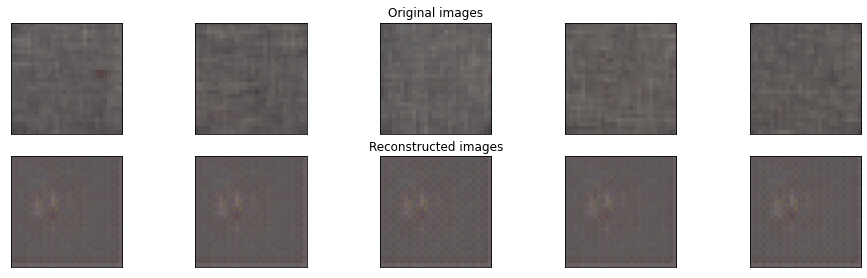

	 partial train loss (single batch): 0.001421
	 partial train loss (single batch): 0.001430
	 partial train loss (single batch): 0.001327
	 partial train loss (single batch): 0.001383
	 partial train loss (single batch): 0.001398
	 partial train loss (single batch): 0.001360
	 partial train loss (single batch): 0.001363
	 partial train loss (single batch): 0.001256
	 partial train loss (single batch): 0.001369

 EPOCH 9/30 	 train loss 0.0013673551147803664 	 val loss 0.0010340862208977342


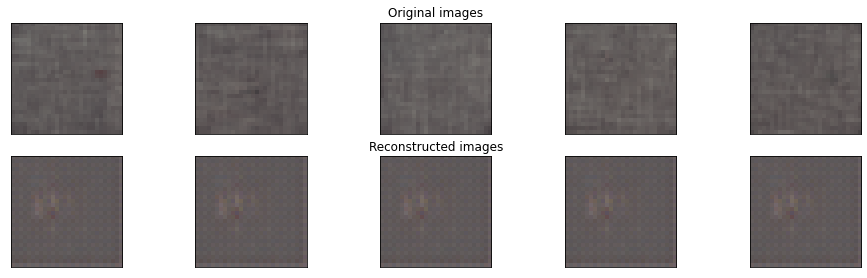

	 partial train loss (single batch): 0.001350
	 partial train loss (single batch): 0.001284
	 partial train loss (single batch): 0.001283
	 partial train loss (single batch): 0.001298
	 partial train loss (single batch): 0.001245
	 partial train loss (single batch): 0.001252
	 partial train loss (single batch): 0.001276
	 partial train loss (single batch): 0.001283
	 partial train loss (single batch): 0.001184

 EPOCH 10/30 	 train loss 0.0012725851265713573 	 val loss 0.0011021660175174475


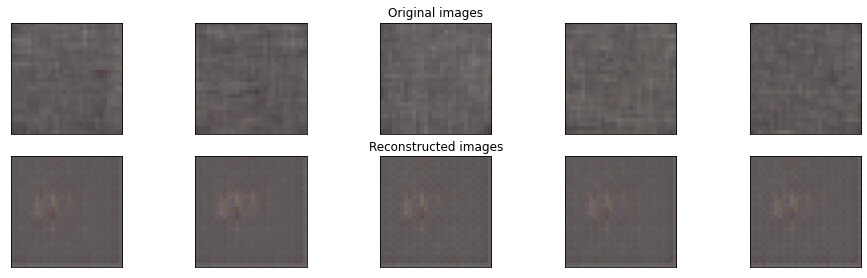

	 partial train loss (single batch): 0.001219
	 partial train loss (single batch): 0.001243
	 partial train loss (single batch): 0.001197
	 partial train loss (single batch): 0.001261
	 partial train loss (single batch): 0.001306
	 partial train loss (single batch): 0.001150
	 partial train loss (single batch): 0.001168
	 partial train loss (single batch): 0.001288
	 partial train loss (single batch): 0.001216

 EPOCH 11/30 	 train loss 0.0012276195921003819 	 val loss 0.0010212934575974941


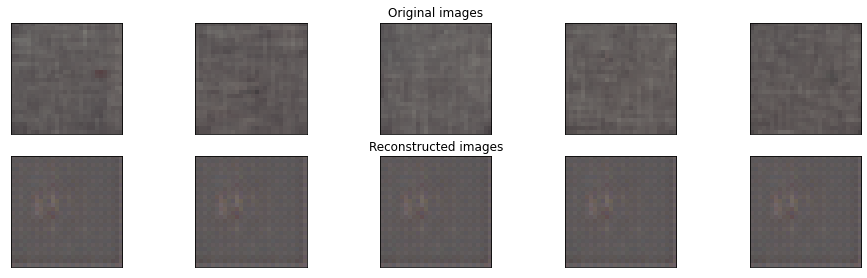

	 partial train loss (single batch): 0.001170
	 partial train loss (single batch): 0.001166
	 partial train loss (single batch): 0.001115
	 partial train loss (single batch): 0.001194
	 partial train loss (single batch): 0.001165
	 partial train loss (single batch): 0.001152
	 partial train loss (single batch): 0.001155
	 partial train loss (single batch): 0.001145
	 partial train loss (single batch): 0.001193

 EPOCH 12/30 	 train loss 0.0011616904521360993 	 val loss 0.0009900027653202415


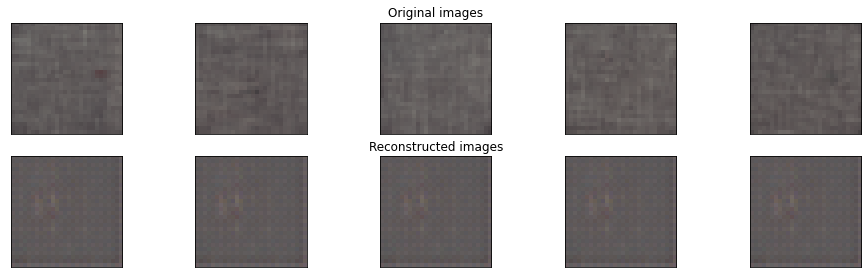

	 partial train loss (single batch): 0.001104
	 partial train loss (single batch): 0.001127
	 partial train loss (single batch): 0.001122
	 partial train loss (single batch): 0.001102
	 partial train loss (single batch): 0.001115
	 partial train loss (single batch): 0.001086
	 partial train loss (single batch): 0.001136
	 partial train loss (single batch): 0.001082
	 partial train loss (single batch): 0.001086

 EPOCH 13/30 	 train loss 0.0011066506849601865 	 val loss 0.000987741630524397


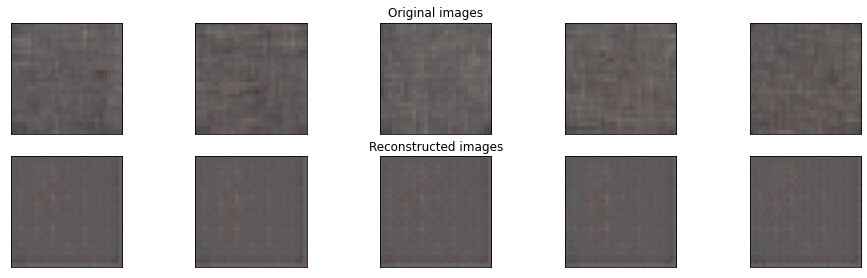

	 partial train loss (single batch): 0.001088
	 partial train loss (single batch): 0.001099
	 partial train loss (single batch): 0.001092
	 partial train loss (single batch): 0.001048
	 partial train loss (single batch): 0.001012
	 partial train loss (single batch): 0.001091
	 partial train loss (single batch): 0.001045
	 partial train loss (single batch): 0.001085
	 partial train loss (single batch): 0.001026

 EPOCH 14/30 	 train loss 0.0010650724871084094 	 val loss 0.001044829492457211


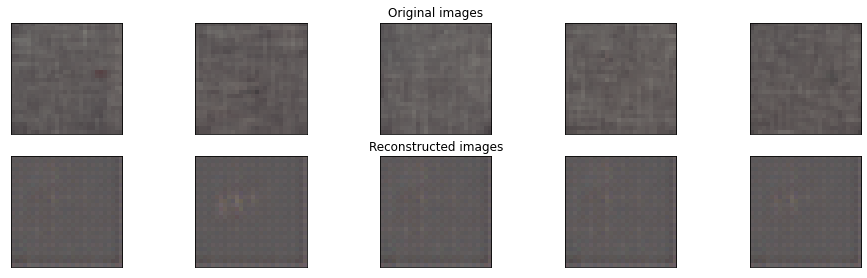

	 partial train loss (single batch): 0.001065
	 partial train loss (single batch): 0.001008
	 partial train loss (single batch): 0.001045
	 partial train loss (single batch): 0.001018
	 partial train loss (single batch): 0.001004
	 partial train loss (single batch): 0.001110
	 partial train loss (single batch): 0.000966
	 partial train loss (single batch): 0.001031
	 partial train loss (single batch): 0.000984

 EPOCH 15/30 	 train loss 0.0010255143279209733 	 val loss 0.0009680403745733202


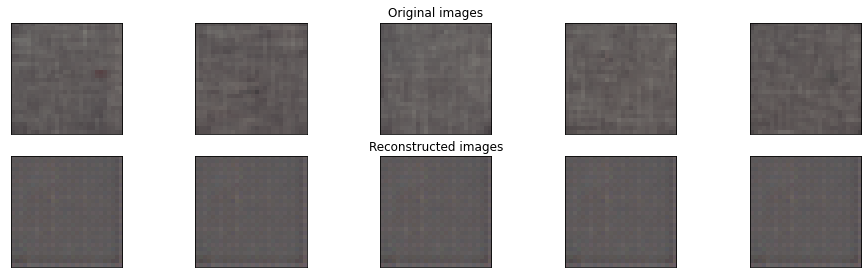

	 partial train loss (single batch): 0.000980
	 partial train loss (single batch): 0.001011
	 partial train loss (single batch): 0.000950
	 partial train loss (single batch): 0.001046
	 partial train loss (single batch): 0.001012
	 partial train loss (single batch): 0.001027
	 partial train loss (single batch): 0.001049
	 partial train loss (single batch): 0.001012
	 partial train loss (single batch): 0.000954

 EPOCH 16/30 	 train loss 0.0010045008966699243 	 val loss 0.0012640407076105475


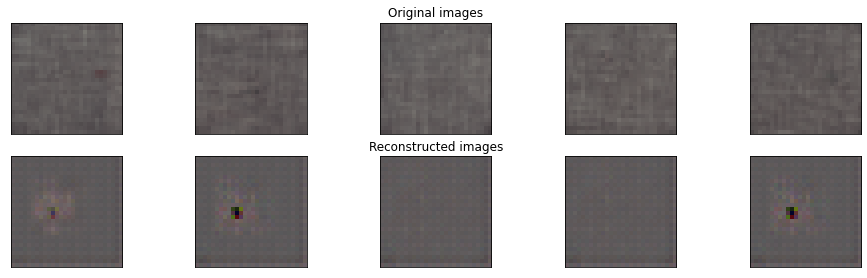

	 partial train loss (single batch): 0.001022
	 partial train loss (single batch): 0.000937
	 partial train loss (single batch): 0.000937
	 partial train loss (single batch): 0.001013
	 partial train loss (single batch): 0.000989
	 partial train loss (single batch): 0.000995
	 partial train loss (single batch): 0.000942
	 partial train loss (single batch): 0.000983
	 partial train loss (single batch): 0.000960

 EPOCH 17/30 	 train loss 0.0009753692429512739 	 val loss 0.0012135033030062914


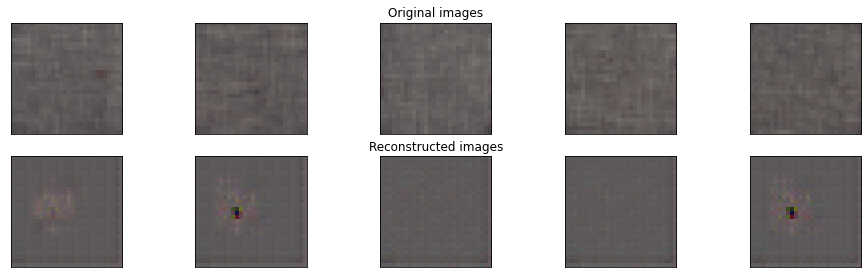

	 partial train loss (single batch): 0.000904
	 partial train loss (single batch): 0.000929
	 partial train loss (single batch): 0.000923
	 partial train loss (single batch): 0.000991
	 partial train loss (single batch): 0.001010
	 partial train loss (single batch): 0.000936
	 partial train loss (single batch): 0.000901
	 partial train loss (single batch): 0.000910
	 partial train loss (single batch): 0.000966

 EPOCH 18/30 	 train loss 0.0009409679914824665 	 val loss 0.0009191739372909069


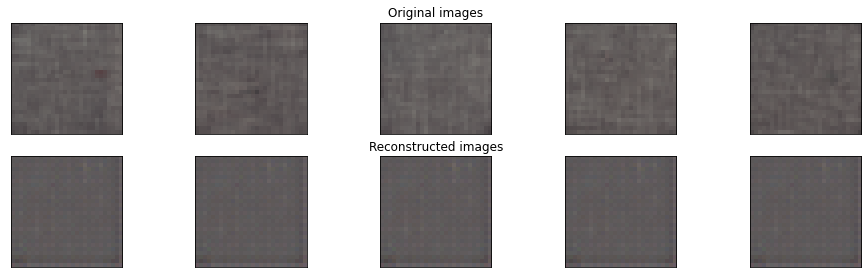

	 partial train loss (single batch): 0.000898
	 partial train loss (single batch): 0.001010
	 partial train loss (single batch): 0.000892
	 partial train loss (single batch): 0.001140
	 partial train loss (single batch): 0.000857
	 partial train loss (single batch): 0.001031
	 partial train loss (single batch): 0.000857
	 partial train loss (single batch): 0.000846
	 partial train loss (single batch): 0.000915

 EPOCH 19/30 	 train loss 0.0009384492877870798 	 val loss 0.006115925498306751


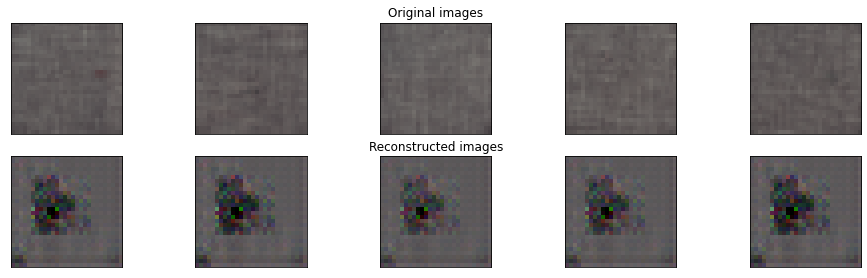

	 partial train loss (single batch): 0.000887
	 partial train loss (single batch): 0.001019
	 partial train loss (single batch): 0.000846
	 partial train loss (single batch): 0.000876
	 partial train loss (single batch): 0.000851
	 partial train loss (single batch): 0.000840
	 partial train loss (single batch): 0.000860
	 partial train loss (single batch): 0.000850
	 partial train loss (single batch): 0.000886

 EPOCH 20/30 	 train loss 0.0008795096073299646 	 val loss 0.0009287658031098545


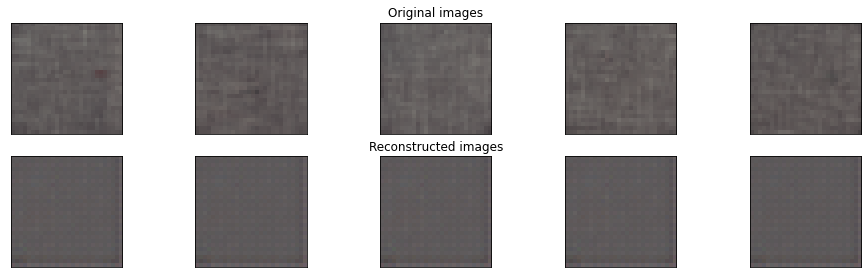

	 partial train loss (single batch): 0.000914
	 partial train loss (single batch): 0.000801
	 partial train loss (single batch): 0.000786
	 partial train loss (single batch): 0.000818
	 partial train loss (single batch): 0.000811
	 partial train loss (single batch): 0.000897
	 partial train loss (single batch): 0.000845
	 partial train loss (single batch): 0.000822
	 partial train loss (single batch): 0.000810

 EPOCH 21/30 	 train loss 0.0008337176986970007 	 val loss 0.0010051866993308067


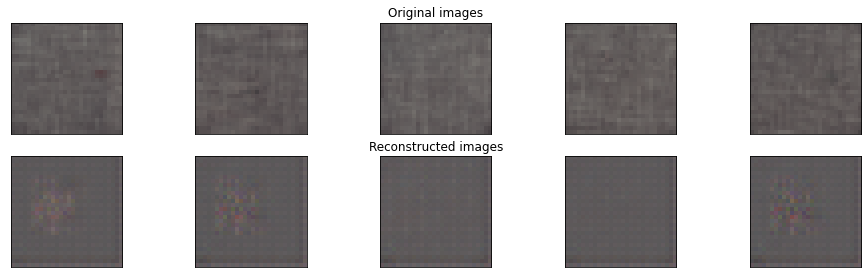

	 partial train loss (single batch): 0.000816
	 partial train loss (single batch): 0.000792
	 partial train loss (single batch): 0.000793
	 partial train loss (single batch): 0.000771
	 partial train loss (single batch): 0.000809
	 partial train loss (single batch): 0.000775
	 partial train loss (single batch): 0.000790
	 partial train loss (single batch): 0.000896
	 partial train loss (single batch): 0.000817

 EPOCH 22/30 	 train loss 0.00080635875929147 	 val loss 0.0009044925100170076


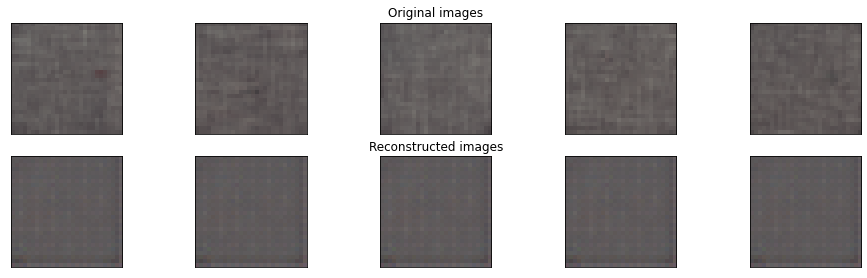

	 partial train loss (single batch): 0.000821
	 partial train loss (single batch): 0.000790
	 partial train loss (single batch): 0.000782
	 partial train loss (single batch): 0.000822
	 partial train loss (single batch): 0.000794
	 partial train loss (single batch): 0.000850
	 partial train loss (single batch): 0.000738
	 partial train loss (single batch): 0.000774
	 partial train loss (single batch): 0.000815

 EPOCH 23/30 	 train loss 0.0007985057309269905 	 val loss 0.0008923037094064057


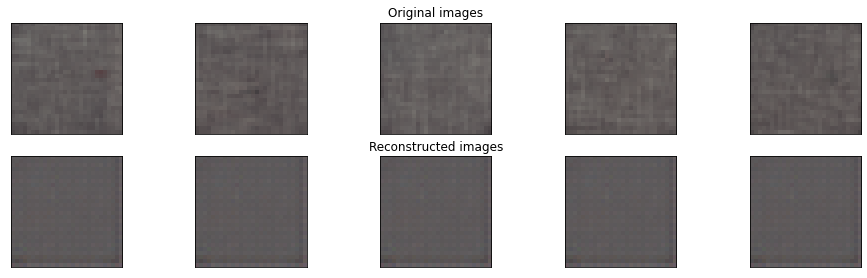

	 partial train loss (single batch): 0.000742
	 partial train loss (single batch): 0.000827
	 partial train loss (single batch): 0.000878
	 partial train loss (single batch): 0.000760
	 partial train loss (single batch): 0.000771
	 partial train loss (single batch): 0.000837
	 partial train loss (single batch): 0.000859
	 partial train loss (single batch): 0.000780
	 partial train loss (single batch): 0.000790

 EPOCH 24/30 	 train loss 0.0008050549076870084 	 val loss 0.0008751674322411418


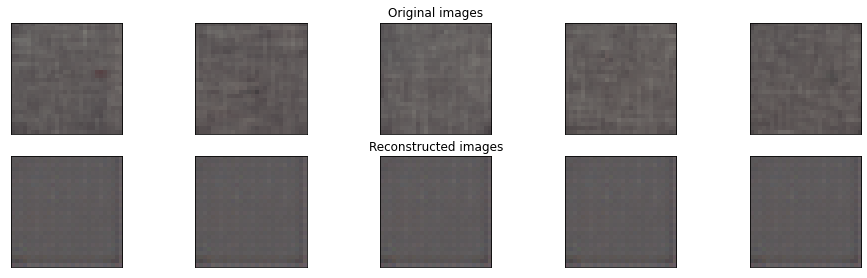

	 partial train loss (single batch): 0.000848
	 partial train loss (single batch): 0.000743
	 partial train loss (single batch): 0.000786
	 partial train loss (single batch): 0.000785
	 partial train loss (single batch): 0.000712
	 partial train loss (single batch): 0.000841
	 partial train loss (single batch): 0.000751
	 partial train loss (single batch): 0.000765
	 partial train loss (single batch): 0.000842

 EPOCH 25/30 	 train loss 0.000786022690590471 	 val loss 0.0008738932083360851


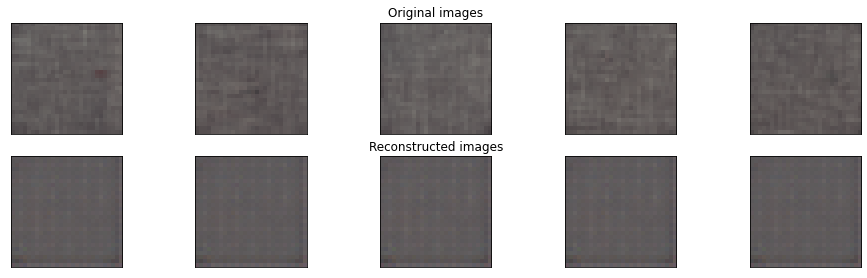

	 partial train loss (single batch): 0.000764
	 partial train loss (single batch): 0.000798
	 partial train loss (single batch): 0.000767
	 partial train loss (single batch): 0.000752
	 partial train loss (single batch): 0.000724
	 partial train loss (single batch): 0.000735
	 partial train loss (single batch): 0.000737
	 partial train loss (single batch): 0.000753
	 partial train loss (single batch): 0.000711

 EPOCH 26/30 	 train loss 0.0007490874850191176 	 val loss 0.0008619276341050863


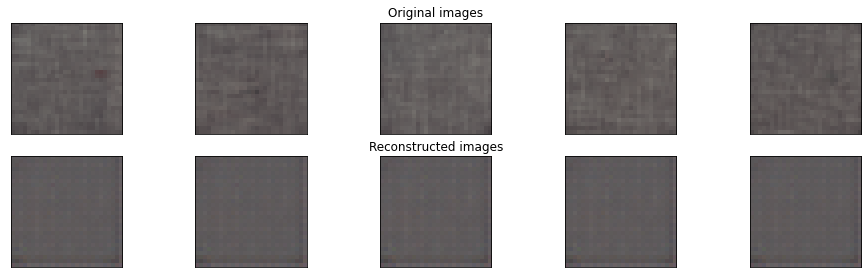

	 partial train loss (single batch): 0.000702
	 partial train loss (single batch): 0.000722
	 partial train loss (single batch): 0.000760
	 partial train loss (single batch): 0.000738
	 partial train loss (single batch): 0.000735
	 partial train loss (single batch): 0.000718
	 partial train loss (single batch): 0.000749
	 partial train loss (single batch): 0.000716
	 partial train loss (single batch): 0.000712

 EPOCH 27/30 	 train loss 0.0007279633427970111 	 val loss 0.0008517769165337086


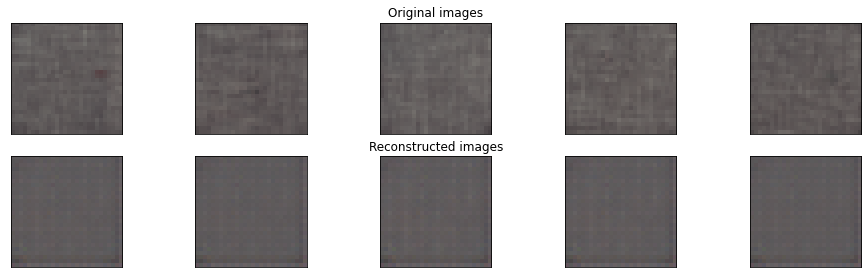

	 partial train loss (single batch): 0.000750
	 partial train loss (single batch): 0.000712
	 partial train loss (single batch): 0.000735
	 partial train loss (single batch): 0.000729
	 partial train loss (single batch): 0.000702
	 partial train loss (single batch): 0.000686
	 partial train loss (single batch): 0.000721
	 partial train loss (single batch): 0.000716
	 partial train loss (single batch): 0.000717

 EPOCH 28/30 	 train loss 0.0007185733411461115 	 val loss 0.0008538057445548475


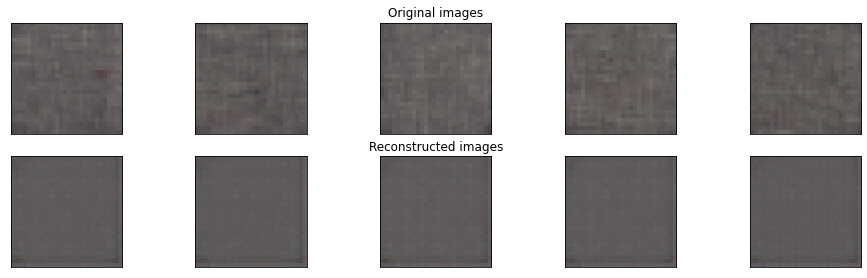

	 partial train loss (single batch): 0.000778
	 partial train loss (single batch): 0.000676
	 partial train loss (single batch): 0.000750
	 partial train loss (single batch): 0.000742
	 partial train loss (single batch): 0.000724
	 partial train loss (single batch): 0.000740
	 partial train loss (single batch): 0.000703
	 partial train loss (single batch): 0.000766
	 partial train loss (single batch): 0.000719

 EPOCH 29/30 	 train loss 0.000733173219487071 	 val loss 0.0008514677174389362


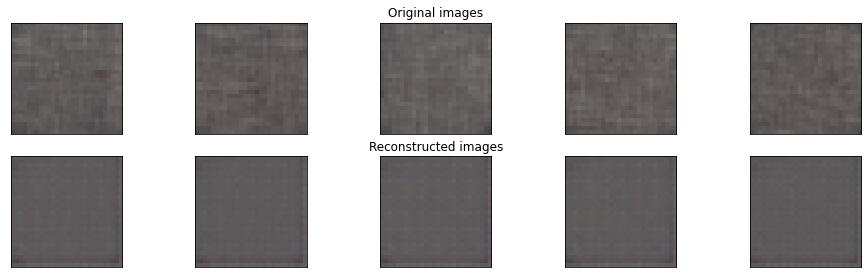

	 partial train loss (single batch): 0.000703
	 partial train loss (single batch): 0.000674
	 partial train loss (single batch): 0.000769
	 partial train loss (single batch): 0.000801
	 partial train loss (single batch): 0.000724
	 partial train loss (single batch): 0.000693
	 partial train loss (single batch): 0.000704
	 partial train loss (single batch): 0.000730
	 partial train loss (single batch): 0.000859

 EPOCH 30/30 	 train loss 0.0007396551663987339 	 val loss 0.0008521729614585638


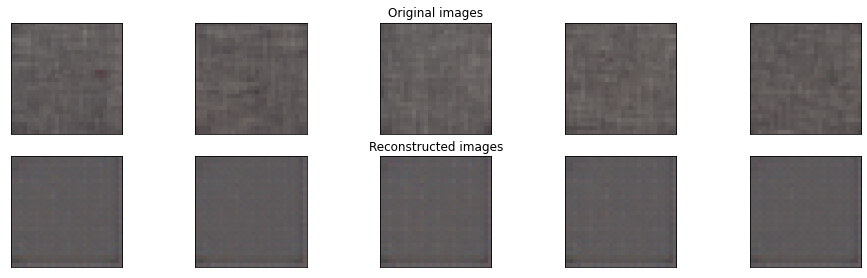

In [20]:
num_epochs = 30
c_diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   c_train_loss =train_epoch(encoder,decoder,device,
   carpet_train_loader,loss_fn,optim)
   c_val_loss = test_epoch(encoder,decoder,device,carpet_test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,c_train_loss,c_val_loss))
   c_diz_loss['train_loss'].append(c_train_loss)
   c_diz_loss['val_loss'].append(c_val_loss)
   plot_ae_outputs(encoder,decoder,carpet_vis_test_loader,n=5)

In [21]:
test_epoch(encoder,decoder,device,hazelnut_test_loader,loss_fn).item()

0.04137761890888214

In [22]:
test_epoch(encoder,decoder,device,carpet_test_loader,loss_fn).item()

0.0008521729032509029

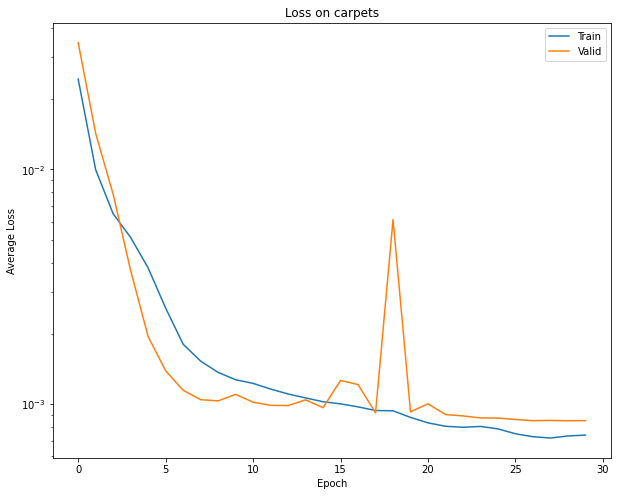

In [23]:
# Plot losses fpr carpets
plt.figure(figsize=(10,8))
plt.semilogy(c_diz_loss['train_loss'], label='Train')
plt.semilogy(c_diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
plt.title('Loss on carpets')
plt.show()

# Latent dimension visualization 

Basically what we do here is use the encoder to generate the latent vectors. We calculate the mean and the standard deviation of the latent dimension then sample random outputs from this distribution (this is like generating inputs for our decoder). After that we use our decoder to generate images.

tensor([ 49.2598, -24.6378, -54.0366, -43.7346])
tensor([5.3691, 2.4661, 5.9002, 4.5062])


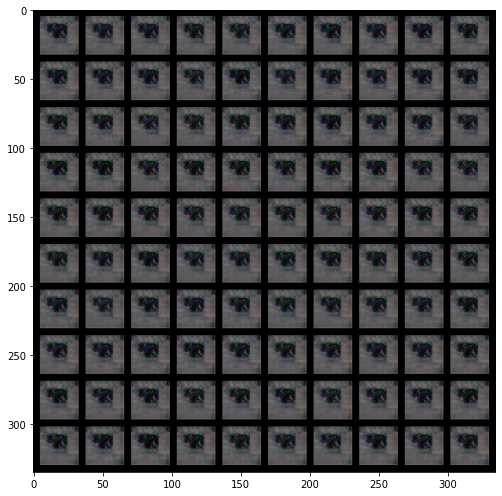

In [24]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = iter(hazelnut_test_loader).next()
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()

We do the before mentioned funcionality with our carpet image dataset.

tensor([-0.9903, -0.7937,  1.1940, -0.9699])
tensor([0.6309, 0.1609, 0.7464, 0.3047])


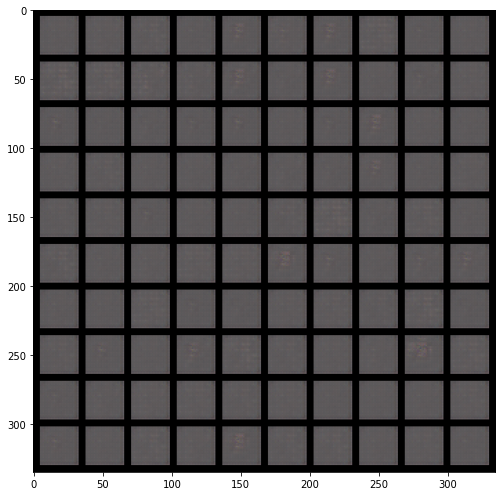

In [25]:
encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = iter(carpet_test_loader).next()
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()

This is basically a test loop in which we keep our encoded images in a dataset for later visualization

In [26]:
from tqdm import tqdm

encoded_samples = []
for sample in tqdm(hazelnut_test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 88/88 [00:05<00:00, 16.69it/s]


Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  label
0         52.216778       -25.852077       -57.284660       -46.020763      2
1         48.541355       -24.509806       -53.379700       -43.345165      3
2         48.724079       -24.385937       -53.450722       -43.260105      3
3         44.552586       -22.588017       -48.804546       -39.826405      2
4         52.382931       -26.536083       -57.394741       -46.709019      4
..              ...              ...              ...              ...    ...
83        48.055836       -24.331100       -52.796276       -42.999317      3
84        40.775238       -20.906862       -44.666641       -36.539318      2
85        48.752964       -24.570316       -53.390869       -43.407585      1
86        43.729092       -21.659397       -47.904518       -38.754284      2
87        51.213825       -25.146942       -56.224686       -45.179317      3

[88 rows x 5 columns]

# Visualize encoded variables on a scatterplot

In [27]:

import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7)

# Use t-SNE for clustering

In [28]:

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

